<a href="https://colab.research.google.com/github/XAheli/Predicting-Indian-Stocks-Price-with-Stacked-LSTM/blob/main/Indian_Stocks_Prediction_using_Stacked_Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  1. Data Preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from typing import Any, Literal
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
!pip install nsepython
import nsepython as nse
import logging
import duckdb

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

from huggingface_hub.inference_api import InferenceApi
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas_datareader.data import DataReader
import warnings
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")


In [ ]:
!git clone  https://github.com/Biswajit-Behera/Quantitative-Portfolio-Rebalancing-Stock-Price-Prediction.git

fatal: destination path 'Quantitative-Portfolio-Rebalancing-Stock-Price-Prediction' already exists and is not an empty directory.


## 1.1 Uploding the Personal Protfolio

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/CSE/4.2/CSE4214 - Pattern Recognition Lab/Project/text_emotions.csv')
df = pd.read_csv('https://raw.githubusercontent.com/Biswajit-Behera/Quantitative-Portfolio-Rebalancing-Stock-Price-Prediction/refs/heads/main/protfolio.csv')
df

# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/Copy of text_emotions.csv')
# df['sentiment'].unique()

Company Name Stock Symbol Market Cap Category  \
0           Reliance Industries     RELIANCE           Large Cap   
1     Tata Consultancy Services          TCS           Large Cap   
2                     HDFC Bank     HDFCBANK           Large Cap   
3                       Infosys         INFY           Large Cap   
4               Larsen & Toubro           LT             Mid Cap   
5                        Zomato       ZOMATO             Mid Cap   
6                       Coforge      COFORGE             Mid Cap   
7               Bharat Dynamics          BDL           Small Cap   
8           Nazara Technologies       NAZARA           Small Cap   
9   Happiest Minds Technologies   HAPPSTMNDS           Small Cap   
10                        Total          NaN                 NaN   

    Investment (INR)  Return (%)  Total Return (INR) Yahoo Finance Ticker  \
0             100000        12.0             12000.0          RELIANCE.NS   
1             120000        10.0             12000.0               TCS.NS   
2              90000         8.0              7200.0          HDFCBANK.NS   
3              80000        15.0             12000.0              INFY.NS   
4              70000        18.0             12600.0                LT.NS   
5              60000        25.0             15000.0            ZOMATO.NS   
6              50000        20.0             10000.0           COFORGE.NS   
7              40000        30.0             12000.0               BDL.NS   
8              30000        35.0             10500.0            NAZARA.NS   
9              25000        40.0             10000.0        HAPPSTMNDS.NS   
10            665000         NaN            113300.0                  NaN   

    Weightage in Portfolio (%)  CMP (INR)  
0                    15.037594     2800.0  
1                    18.045113     3650.0  
2                    13.533835     1570.0  
3                    12.030075     1650.0  
4                    10.526316     3050.0  
5                     9.022556      120.0  
6                     7.518797     5500.0  
7                     6.015038     1400.0  
8                     4.511278      780.0  
9                     3.759398      875.0  
10                         NaN        NaN

In [ ]:
# Remove the last row (Total Row)
df = df.iloc[:-1]
# Store values in variables
stock_symbols = df["Yahoo Finance Ticker"].tolist()
weightage_portfolio = df["Weightage in Portfolio (%)"].tolist()
company_names = df["Company Name"].tolist()

# Print the stored values
print("Yahoo Finance Tickers:", stock_symbols)
print("Weightage in Portfolio (%):", weightage_portfolio)
print("Company Names:", company_names)

Yahoo Finance Tickers: ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'LT.NS', 'ZOMATO.NS', 'COFORGE.NS', 'BDL.NS', 'NAZARA.NS', 'HAPPSTMNDS.NS']
Weightage in Portfolio (%): [15.037593984962406, 18.045112781954884, 13.533834586466163, 12.030075187969924, 10.526315789473683, 9.022556390977442, 7.518796992481203, 6.015037593984962, 4.511278195488721, 3.7593984962406015]
Company Names: ['Reliance Industries', 'Tata Consultancy Services', 'HDFC Bank', 'Infosys', 'Larsen & Toubro', 'Zomato', 'Coforge', 'Bharat Dynamics', 'Nazara Technologies', 'Happiest Minds Technologies']


# 2) Sentiment Analysis

In [ ]:
import concurrent.futures

## 2.1) Constants and Global Variables

In [ ]:
universe = "nifty_500"
news_url = "https://www.google.com/finance/quote"
header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0"
}
token = os.getenv("HF_TOKEN") # Hugging Face Token
sentiment_model = InferenceApi(
    "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", token=token
)

##2.3)  Get the list of stocks in the universe

In [ ]:
def fetch_tickers() -> None:
    """
    Fetches the tickers for the specified Nifty index.

    Returns:
        pandas.DataFrame: A DataFrame containing the tickers and company names.
    """

    # check if a directory datasets exists in root folder if not then create it
    if not os.path.exists("./datasets"):
        os.makedirs("./datasets")

    # Dictionary to store the URLs for the different Nifty indices
    tickers_url_dict: dict = {
        "nifty_500": "https://archives.nseindia.com/content/indices/ind_nifty500list.csv",
        "nifty_200": "https://archives.nseindia.com/content/indices/ind_nifty200list.csv",
        "nifty_100": "https://archives.nseindia.com/content/indices/ind_nifty100list.csv",
        "nifty_50": "https://archives.nseindia.com/content/indices/ind_nifty50list.csv",
    }

    logging.info(f"Downloading Tickers List for {list(tickers_url_dict.keys())}")

    for index_name in tickers_url_dict.keys():
        try:
            ticker_list_url = tickers_url_dict[index_name]
            ticker_list_df = pd.read_csv(ticker_list_url)
            ticker_list_df.to_csv(f"./datasets/{index_name}.csv")
        except Exception as e:
            logging.warning(f"Error fetching tickers for {index_name}: {e}")

In [ ]:
# Function to fetch NIFTY 500 stock symbols
def fetch_nifty500_tickers():
    url = "https://archives.nseindia.com/content/indices/ind_nifty500list.csv"
    tickers_df = pd.read_csv(url)

    # Create the 'datasets' directory if it doesn't exist
    import os # make sure to import os module
    os.makedirs("./datasets", exist_ok=True)

    # Ensure correct column naming and save the dataset
    tickers_df.to_csv("./datasets/nifty_500.csv", index=False)
    return tickers_df

# Fetch and read the ticker symbols
tickers_df = fetch_nifty500_tickers()
tickers_list = tickers_df["Symbol"].tolist()

print("Fetched NIFTY 500 tickers:", tickers_list[:5])  # Display first 5 symbols

Fetched NIFTY 500 tickers: ['360ONE', '3MINDIA', 'ABB', 'ACC', 'AIAENG']


##2.4) Fetch News Data and MetaData

In [ ]:
def get_url_content(
    ticker: str,
) -> tuple[None, None, None] | tuple[str, BeautifulSoup, dict]:
    _ticker: str = ticker + ":NSE"
    url = f"{news_url}/{_ticker}"
    logging.debug(f"Fetching data for {ticker} from {url}")
    try:
        response: requests.Response = requests.get(url, headers=header)
        soup: BeautifulSoup = BeautifulSoup(response.content, "lxml")
    except Exception as e:
        logging.warning(f"Error fetching data for {ticker}: {e}")
        return None, None, None
    meta: dict = nse.nse_eq(ticker)
    return ticker, soup, meta

In [ ]:
def parse_relative_date(date_string) -> None | datetime:
    now = datetime.now()
    parts = date_string.split()

    if len(parts) != 2 and len(parts) != 3:
        return None

    value = int(parts[0]) if parts[0] != "a" else 1
    unit = parts[1]

    if unit.startswith("minute"):
        return now - timedelta(minutes=value)
    elif unit.startswith("hour"):
        return now - timedelta(hours=value)
    elif unit.startswith("day"):
        return now - timedelta(days=value)
    elif unit.startswith("week"):
        return now - timedelta(weeks=value)
    elif unit.startswith("month"):
        return now - relativedelta(months=value)
    else:
        return None

In [ ]:
def ticker_article_fetch(
    ticker, soup
) -> tuple[list, Literal[True]] | tuple[list, Literal[False]]:
    article_data = []
    news_articles: list = soup.select("div.z4rs2b")

    if not news_articles:
        logging.warning(f"No news found for {ticker}")
        return article_data, True

    ticker_articles_counter = 0

    for link in news_articles:
        art_title: str = link.select_one("div.Yfwt5").text.strip().replace("\n", "")
        date_posted_str: str = link.select_one("div.Adak").text
        date_posted: str = parse_relative_date(date_posted_str).strftime(
            "%Y-%m-%d %H:%M:%S"
        )
        source: str = link.select_one("div.sfyJob").text
        article_link: str = link.select_one("a").get("href")

        article_data.append([ticker, art_title, date_posted, source, article_link])
        ticker_articles_counter += 1

    logging.debug(f"No of articles: {ticker_articles_counter} for {ticker}")
    return article_data, False

In [ ]:
def ticker_meta_fetch(ticker: str, meta: dict) -> list:
    try:
        sector: str = meta["industryInfo"]["macro"]
        industry: str = meta["industryInfo"]["industry"]
        mCap: float = round(
            (meta["priceInfo"]["previousClose"] * meta["securityInfo"]["issuedSize"])
            / 1e9,
            2,
        )
        companyName: str = meta["info"]["companyName"]
    except KeyError as e:
        logging.warning(f"Error fetching metadata for {ticker}: {e}")
        sector = industry = mCap = companyName = np.nan
    return [ticker, sector, industry, mCap, companyName]

In [ ]:
def process_ticker(ticker: str) -> dict[str, Any]:
    try:
        ticker, soup, meta = get_url_content(ticker)
        article_data, no_news = ticker_article_fetch(ticker, soup)
        if no_news:
            logging.info(f"Skipping meta check for {ticker}")
            return {
                "ticker": ticker,
                "article_data": [],
                "ticker_meta": None,
                "unavailable": True,
            }
        ticker_meta = ticker_meta_fetch(ticker, meta)
        return {
            "ticker": ticker,
            "article_data": article_data,
            "ticker_meta": ticker_meta,
            "unavailable": False,
        }
    except Exception as e:
        logging.warning(f"Error processing {ticker}: {e}")
        return {
            "ticker": ticker,
            "article_data": [],
            "ticker_meta": None,
            "unavailable": True,
        }

In [ ]:
ticker_data = []

with concurrent.futures.ThreadPoolExecutor(max_workers=mp.cpu_count()) as executor:


    futures = [executor.submit(process_ticker, ticker) for ticker in tickers_list]

    ticker_data = [future.result() for future in tqdm(futures)]
    ticker_data = ticker_data[:500]

100%|██████████| 500/500 [11:34<00:00,  1.39s/it]


In [ ]:
article_data = []
ticker_meta = []
unavailable_tickers = []

for result in ticker_data:
    if result["unavailable"]:
        unavailable_tickers.append(result["ticker"])
    else:
        article_data.extend(result["article_data"])
        ticker_meta.append(result["ticker_meta"])

In [ ]:
logging.info(f"No news data available for: {unavailable_tickers}")

In [ ]:
article_df = pd.DataFrame(
    article_data,
    columns=["ticker", "headline", "date_posted", "source", "article_link"],
)
article_df.head(50)

ticker                                           headline  \
0       360ONE  Volatility Traders Revel in S&P 500’s Wild Tar...   
1       360ONE  Asian Equities Poised for Weak Open, Futures D...   
2       360ONE  Stock futures fall on Monday morning after S&P...   
3       360ONE  Dow Jones Futures Fall; Trump Won't Rule Out R...   
4       360ONE  Veteran fund manager who correctly forecast S&...   
5       360ONE  Stock market today: Dow, S&P 500, Nasdaq diver...   
6      3MINDIA  Volatility Traders Revel in S&P 500’s Wild Tar...   
7      3MINDIA  Asian Equities Poised for Weak Open, Futures D...   
8      3MINDIA  Stock futures fall on Monday morning after S&P...   
9      3MINDIA  Dow Jones Futures Fall; Trump Won't Rule Out R...   
10     3MINDIA  Veteran fund manager who correctly forecast S&...   
11     3MINDIA  Stock market today: Dow, S&P 500, Nasdaq diver...   
12         ABB  Volatility Traders Revel in S&P 500’s Wild Tar...   
13         ABB  Asian Equities Poised for Weak Open, Futures D...   
14         ABB  Stock futures fall on Monday morning after S&P...   
15         ABB  Dow Jones Futures Fall; Trump Won't Rule Out R...   
16         ABB  Veteran fund manager who correctly forecast S&...   
17         ABB  Stock market today: Dow, S&P 500, Nasdaq diver...   
18         ACC              Weak Margins Amidst Structural Growth   
19         ACC                       UltraTech Cement Share Price   
20      AIAENG  Volatility Traders Revel in S&P 500’s Wild Tar...   
21      AIAENG  Asian Equities Poised for Weak Open, Futures D...   
22      AIAENG  Stock futures fall on Monday morning after S&P...   
23      AIAENG  Dow Jones Futures Fall; Trump Won't Rule Out R...   
24      AIAENG  Veteran fund manager who correctly forecast S&...   
25      AIAENG  Stock market today: Dow, S&P 500, Nasdaq diver...   
26   APLAPOLLO  Volatility Traders Revel in S&P 500’s Wild Tar...   
27   APLAPOLLO  Asian Equities Poised for Weak Open, Futures D...   
28   APLAPOLLO  Stock futures fall on Monday morning after S&P...   
29   APLAPOLLO  Dow Jones Futures Fall; Trump Won't Rule Out R...   
30   APLAPOLLO  Veteran fund manager who correctly forecast S&...   
31   APLAPOLLO  Stock market today: Dow, S&P 500, Nasdaq diver...   
32      AUBANK  AU Small Finance Bank to raise ₹1,500 crore vi...   
33      AUBANK  Top stocks of the week: JSW Infra, Shriram Fin...   
34   AADHARHFC  Aadhar Housing: Growth story continues with st...   
35   AADHARHFC              AADHAR HOUSING FINANCE Board Meetings   
36   AADHARHFC  AADHAR HOUSING FINANCE Cashflow: Cashflow, Cas...   
37    AARTIIND  Volatility Traders Revel in S&P 500’s Wild Tar...   
38    AARTIIND  Asian Equities Poised for Weak Open, Futures D...   
39    AARTIIND  Stock futures fall on Monday morning after S&P...   
40    AARTIIND  Dow Jones Futures Fall; Trump Won't Rule Out R...   
41    AARTIIND  Veteran fund manager who correctly forecast S&...   
42    AARTIIND  Stock market today: Dow, S&P 500, Nasdaq diver...   
43       AAVAS  Aavas Financiers share price surges 9% on heav...   
44       AAVAS  Aavas Financiers shares surge 9% amid high tra...   
45       AAVAS      Volumes spurt at AAVAS Financiers Ltd counter   
46       AAVAS  Aavas Financiers Reports Strong Financial Grow...   
47  ABBOTINDIA  This pharma stock hits all-time high, surges o...   
48         ACE  Volatility Traders Revel in S&P 500’s Wild Tar...   
49         ACE  Asian Equities Poised for Weak Open, Futures D...   

            date_posted                     source  \
0   2025-03-09 16:16:36              Bloomberg.com   
1   2025-03-10 07:16:36              Bloomberg.com   
2   2025-03-10 07:16:36                       CNBC   
3   2025-03-10 06:16:36  Investor's Business Daily   
4   2025-03-09 08:16:36                  TheStreet   
5   2025-03-08 08:16:36              Yahoo Finance   
6   2025-03-09 16:16:36              Bloomberg.com   
7   2025-03-10 07:16:36              Bloomberg.com   
8 

In [ ]:
ticker_meta_df = pd.DataFrame(
    ticker_meta,
    columns=["ticker", "sector", "industry", "marketCap", "companyName"],
)

In [ ]:
articles_list = article_df['headline'].astype(str).tolist()

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(articles_list)
sequences = tokenizer.texts_to_sequences(articles_list)

# Padding sequences
max_length = 50  # Adjust based on data
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Sample labels (Assuming 3 categories: Positive, Neutral, Negative)
labels = np.random.randint(0, 3, size=(len(padded_sequences),))  # Placeholder labels
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [ ]:
# Define LSTM model
model = Sequential([
    Embedding(5000, 64, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(3, activation='softmax')  # 3 sentiment categories
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3230 - loss: 1.1012 - val_accuracy: 0.3296 - val_loss: 1.0991
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3319 - loss: 1.0987 - val_accuracy: 0.3341 - val_loss: 1.0995
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3515 - loss: 1.0974 - val_accuracy: 0.3341 - val_loss: 1.0993
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3538 - loss: 1.0971 - val_accuracy: 0.3341 - val_loss: 1.0989
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3453 - loss: 1.0985 - val_accuracy: 0.3185 - val_loss: 1.0991
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3253 - loss: 1.0988 - val_accuracy: 0.3296 - val_loss: 1.0996
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3438 - loss: 1.0981 - val_accuracy: 0.3341 - val_loss: 1.1012
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3737 - loss: 1.0947 - val_accuracy: 0.29

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
  Sentiment  Count
0   Bearish     67
1   Neutral    340
2   Bullish     42


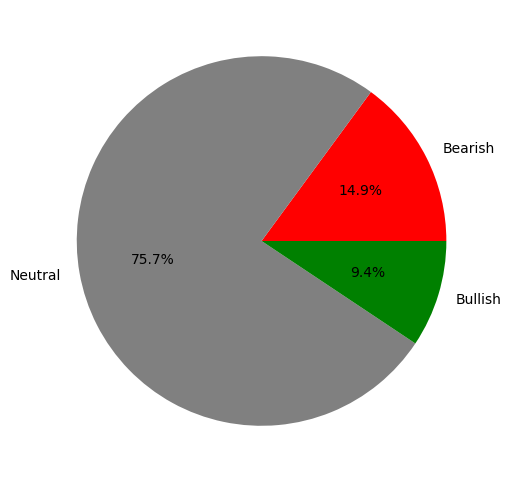

In [ ]:

predicted_labels = model.predict(X_test).argmax(axis=1)

# Ensure all sentiment categories exist
sentiment_labels = ['Bearish', 'Neutral', 'Bullish']
sentiment_counts = pd.Series(predicted_labels).value_counts().sort_index()

# Create a dictionary to ensure all categories are present
sentiment_dict = {i: sentiment_counts.get(i, 0) for i in range(3)}  # Default to 0 if missing

# Convert to DataFrame for tabular representation
sentiment_df = pd.DataFrame({
    'Sentiment': [sentiment_labels[i] for i in sentiment_dict.keys()],
    'Count': list(sentiment_dict.values())
})

# Display table
print(sentiment_df)

# Plot Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_df['Count'], labels=sentiment_df['Sentiment'], autopct='%1.1f%%', colors=['red', 'gray', 'green'])
plt.show()

## 3) Protfolio Rebalancing

In [ ]:
# Set the end date to today
end_date = datetime.now().date()

# Set the start date to one year ago
start_date = end_date.replace(year=end_date.year - 1)


In [ ]:

# Create an empty DataFrame to store the stock data
stock_data = pd.DataFrame()

# Fetch and store data for each stock
for symbol in stock_symbols:
    stock = yf.download(symbol, start=start_date, end=end_date)
    stock_data[symbol] = stock['Adj Close'] if 'Adj Close' in stock.columns else stock['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Print the first few rows of the stock data
print(stock_data.head())



            RELIANCE.NS       TCS.NS  HDFCBANK.NS      INFY.NS        LT.NS  \
Date                                                                          
2024-03-14  1421.791016  4092.184570  1435.842896  1625.525879  3580.057617   
2024-03-15  1408.630615  4103.514648  1433.080688  1606.550049  3509.561768   
2024-03-18  1429.736938  4038.595703  1426.569580  1575.726807  3533.424072   
2024-03-19  1415.608154  3868.201660  1429.825073  1535.218750  3474.388184   
2024-03-20  1433.983032  3861.976807  1411.771729  1528.827881  3482.325928   

             ZOMATO.NS   COFORGE.NS      BDL.NS   NAZARA.NS  HAPPSTMNDS.NS  
Date                                                                        
2024-03-14  152.750000  6015.042969  821.453003  647.900024     796.189270  
2024-03-15  160.050003  6043.499512  833.269043  672.099976     787.004639  
2024-03-18  158.250000  5629.246094  830.816589  679.400024     781.593140  
2024-03-19  157.949997  5491.309570  804.410095  674.450012  

In [ ]:
# Create an empty list to store DataFrames for each stock
stock_dfs = []

# Fetch and store data for each stock
for symbol in stock_symbols:
    stock = yf.Ticker(symbol)
    stock_data = stock.history(start=start_date, end=end_date)
    stock_data["Company"] = symbol  # Add a new column with the company's symbol
    stock_dfs.append(stock_data)

# Concatenate the DataFrames into a single DataFrame
data = pd.concat(stock_dfs, axis=0)

# Print the last few rows of the data
print(data.tail())

                                 Open        High    Low       Close  Volume  \
Date                                                                           
2025-03-07 00:00:00+05:30  695.549988  709.849976  692.0  695.450012  311858   
2025-03-10 00:00:00+05:30  699.950012  708.000000  690.0  696.000000  327019   
2025-03-11 00:00:00+05:30  685.450012  700.000000  670.0  695.900024  361731   
2025-03-12 00:00:00+05:30  688.250000  700.000000  683.0  685.450012  289370   
2025-03-13 00:00:00+05:30  693.750000  693.750000  666.0  668.950012  265666   

                           Dividends  Stock Splits        Company  
Date                                                               
2025-03-07 00:00:00+05:30        0.0           0.0  HAPPSTMNDS.NS  
2025-03-10 00:00:00+05:30        0.0           0.0  HAPPSTMNDS.NS  
2025-03-11 00:00:00+05:30        0.0           0.0  HAPPSTMNDS.NS  
2025-03-12 00:00:00+05:30        0.0           0.0  HAPPSTMNDS.NS  
2025-03-13 00:00:00+05:30      

In [ ]:
data.describe()

Open          High          Low        Close        Volume  \
count  2480.000000   2480.000000  2480.000000  2480.000000  2.480000e+03   
mean   2230.377056   2257.985275  2202.016957  2228.817851  1.027142e+07   
std    1979.116174   2004.431602  1951.826153  1978.042109  2.189780e+07   
min     147.100006    157.300003   144.300003   152.750000  4.554000e+04   
25%     913.750000    931.187515   898.260904   912.387497  6.483905e+05   
50%    1482.439165   1498.344411  1466.518590  1482.527405  2.430374e+06   
75%    3580.000000   3612.437439  3536.787476  3574.524963  1.047038e+07   
max    9718.841757  10005.018980  9579.146472  9796.623047  3.890606e+08   

         Dividends  Stock Splits  
count  2480.000000   2480.000000  
mean      0.117550      0.001613  
std       1.859539      0.056785  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max      66.000000      2.000000

# 3. Exploratory Data Analysis of protfolio for Risk Managment

### 3.1 Overview of all  companies

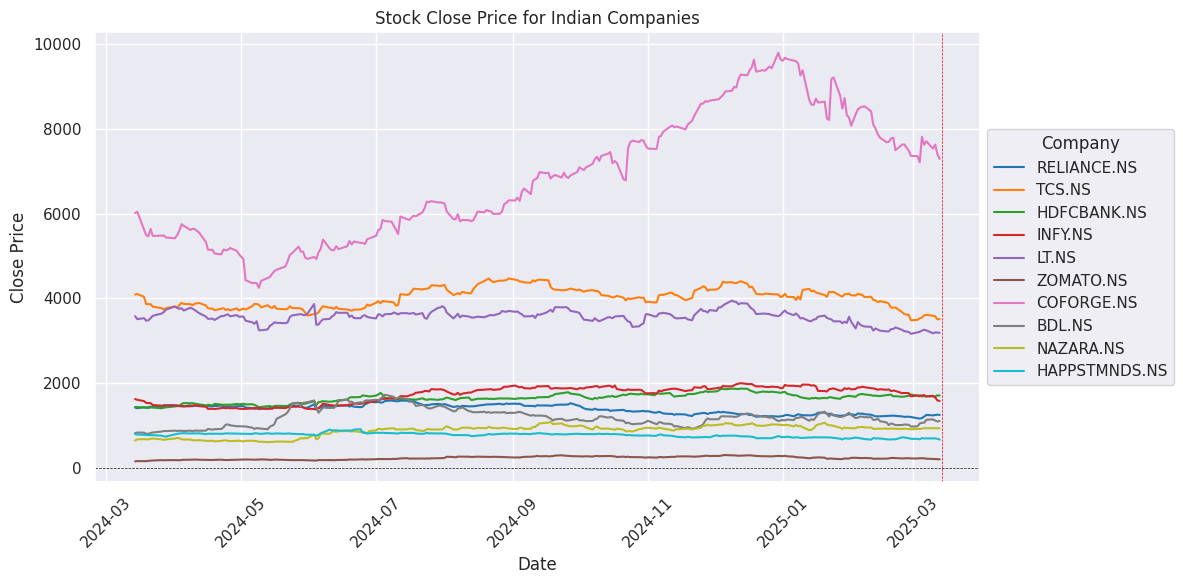

In [ ]:
# Set the style for the plot
sns.set(style="darkgrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the close prices for each company
ax = sns.lineplot(
    x=data.index,
    y="Close",
    data=data,
    hue="Company",
    palette="tab10"
)

# Set titles and labels
ax.set(
    title="Stock Close Price for Indian Companies",
    xlabel="Date",
    ylabel="Close Price"
)

# Display the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Company')

# Rotate x-axis labels
plt.xticks(rotation=45)

# grid lines
ax.grid(True)

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

# horizontal line at y=0 for reference
plt.axvline(end_date, color='red', linestyle='--', linewidth=0.5, label='Today')

# plot
plt.tight_layout()
plt.show()

### 3.2 Adjusted Close Price Each Stock

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume',

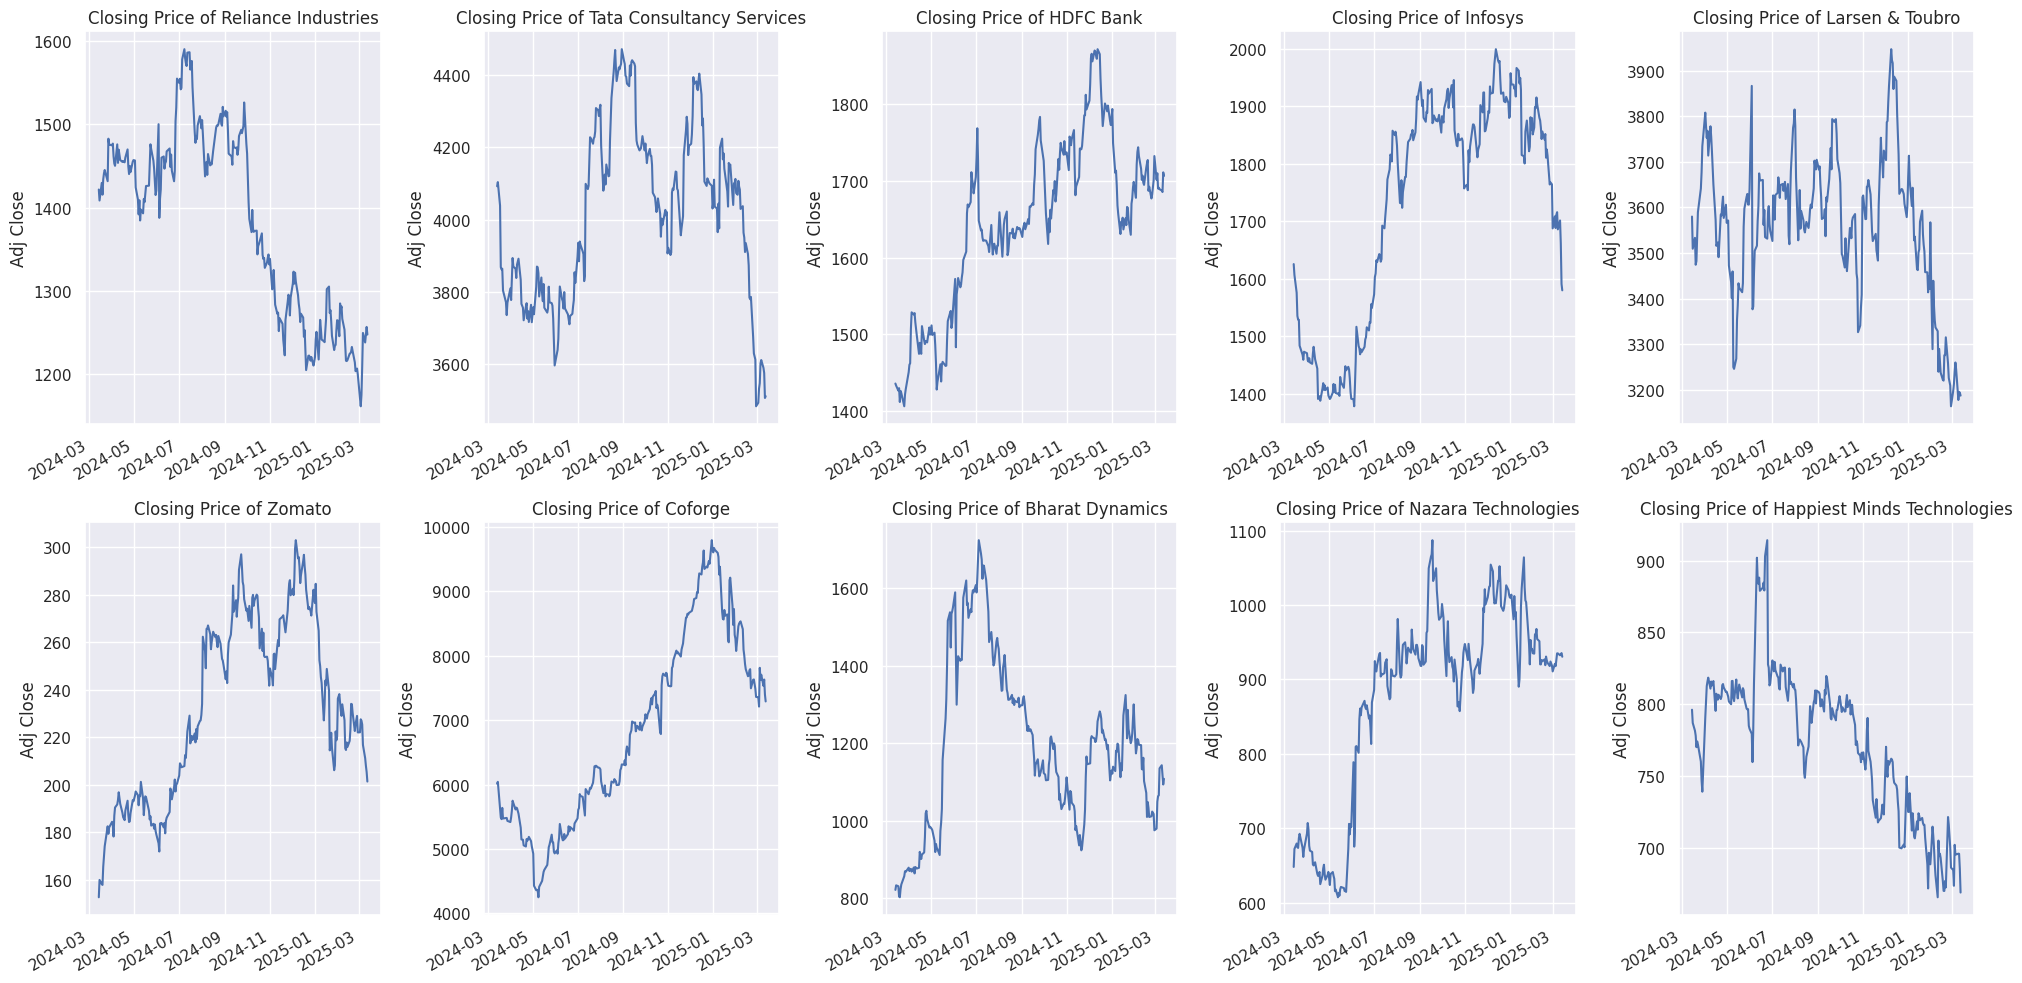

In [ ]:
# Create subplots
num_companies = len(stock_dfs)
num_cols = 5
num_rows = int(np.ceil(num_companies / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
plt.subplots_adjust(top=0.95, bottom=0.05)

for i, (ax, stock_df, company_name) in enumerate(zip(axes.flatten(), stock_dfs, company_names), 1):

    print(stock_df.columns)

    # Update the column name based on the actual column name
    column_name = "Close"

    stock_df[column_name].plot(ax=ax)
    ax.set_ylabel("Adj Close")
    ax.set_xlabel(None)
    ax.set_title(f"Closing Price of {company_name}")

# Hide any empty subplots
for i in range(num_companies, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### 3.3 Total Volume of Stock traded Each Day

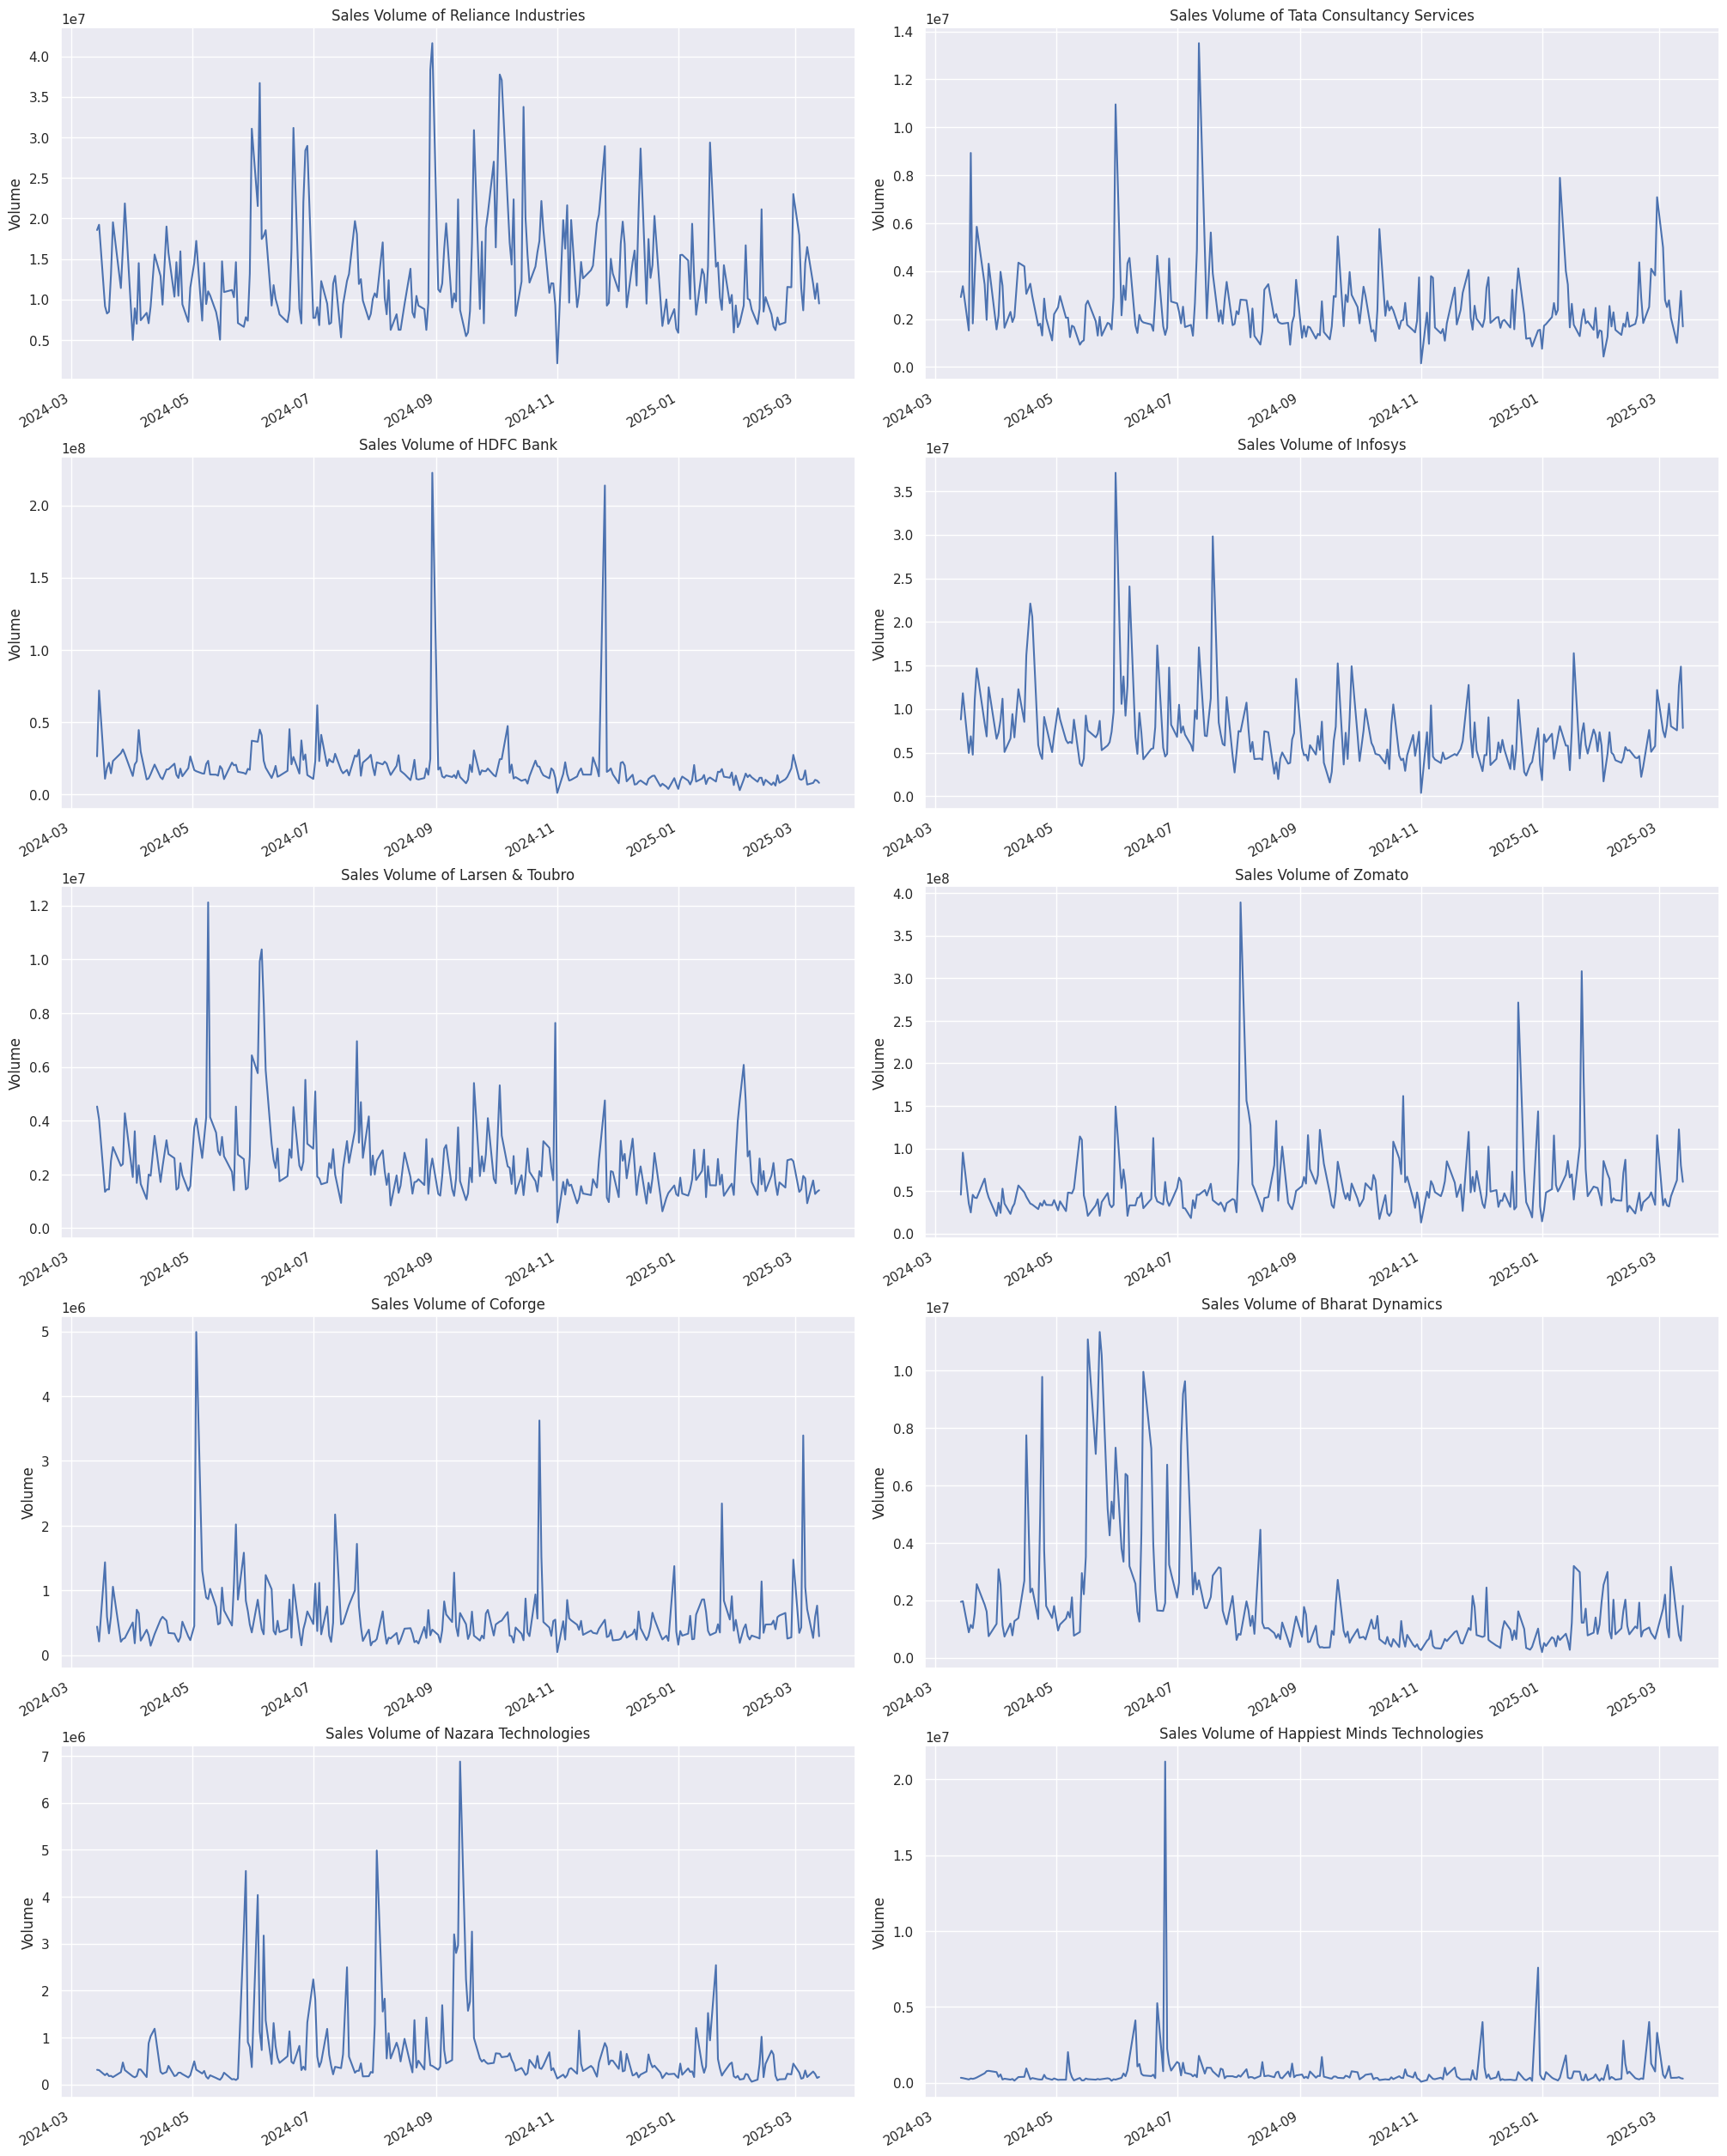

In [ ]:

# Calculate the grid dimensions based on the number of companies
num_companies = len(stock_dfs)
num_cols = 2
num_rows = int(np.ceil(num_companies / num_cols))

# Dynamically set the figure size: 10 inches per column and 5 inches per row
figsize = (num_cols * 10, num_rows * 5)

# Create subplots with constrained_layout to handle spacing
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)

# Flatten the axes array for easy iteration (if only one row, wrap in a list)
axes = np.array(axes).flatten() if num_companies > 1 else [axes]

# Loop over each company and plot its "Volume" series
for ax, stock_df, company_name in zip(axes, stock_dfs, company_names):
    stock_df["Volume"].plot(ax=ax)
    ax.set_ylabel("Volume")
    ax.set_xlabel("")  # remove x-label if not needed
    ax.set_title(f"Sales Volume of {company_name}")

# Hide any extra subplots if there are more axes than companies
for i in range(num_companies, len(axes)):
    fig.delaxes(axes[i])

plt.show()


### 3.4 Moving Average of Each Stock

[*********************100%***********************]  1 of 1 completed


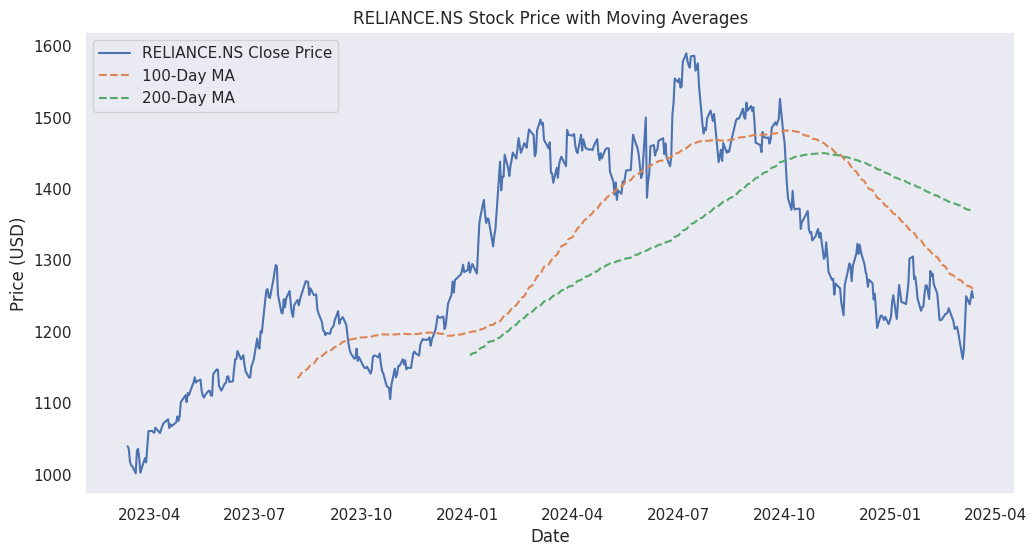

[*********************100%***********************]  1 of 1 completed


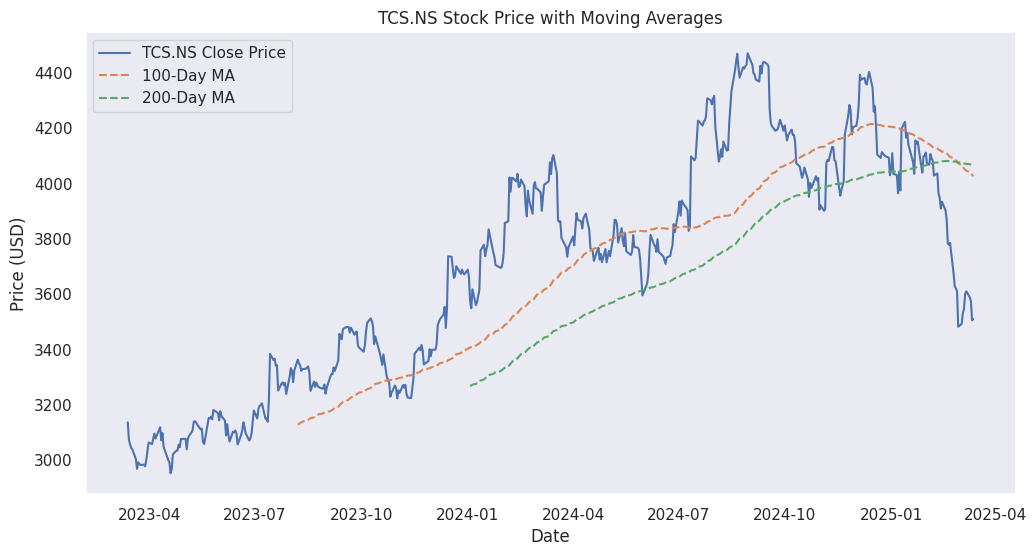

[*********************100%***********************]  1 of 1 completed


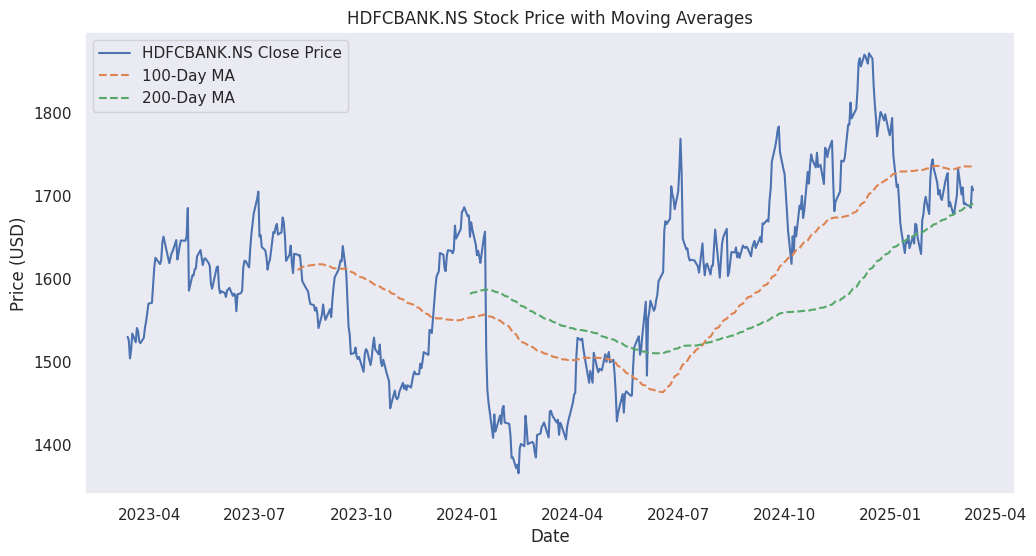

[*********************100%***********************]  1 of 1 completed


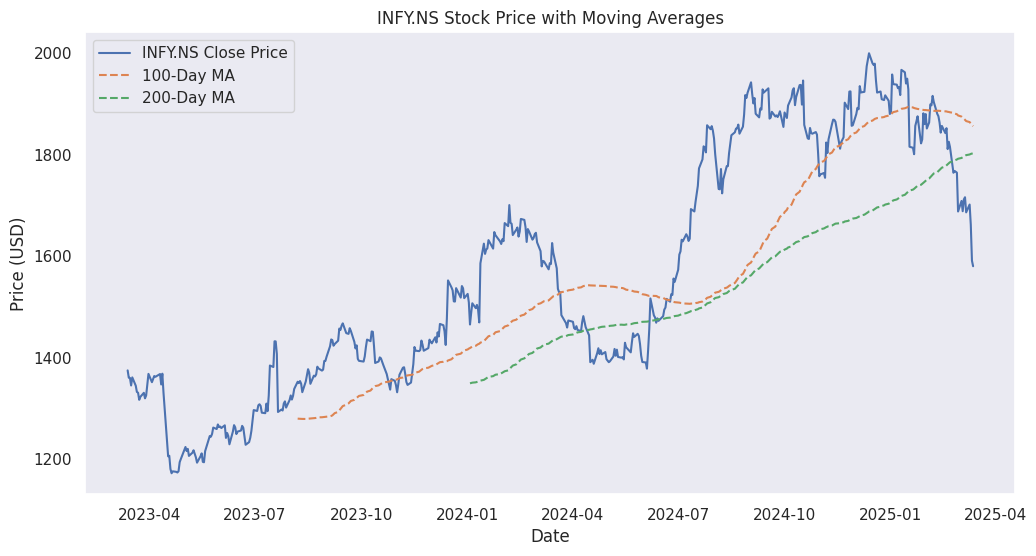

[*********************100%***********************]  1 of 1 completed


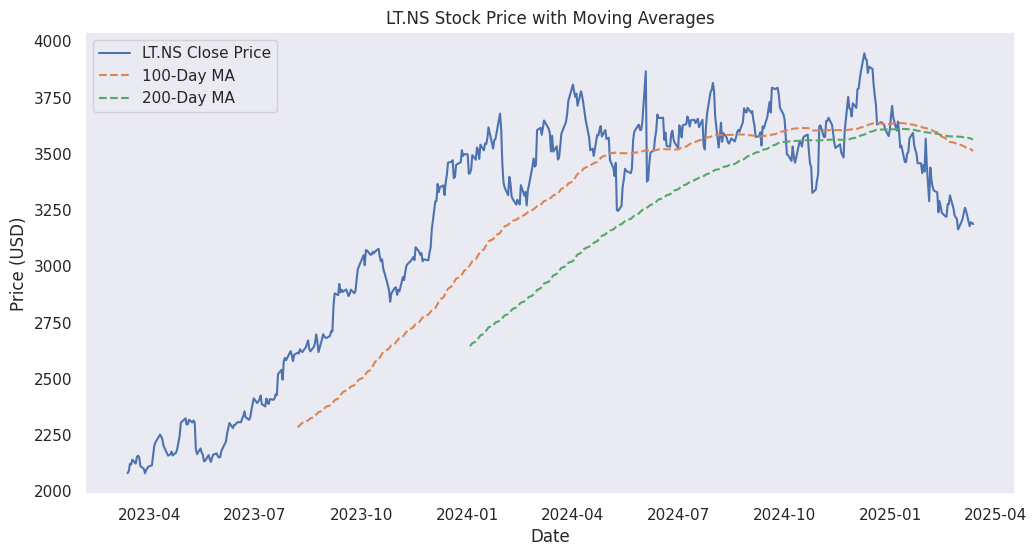

[*********************100%***********************]  1 of 1 completed


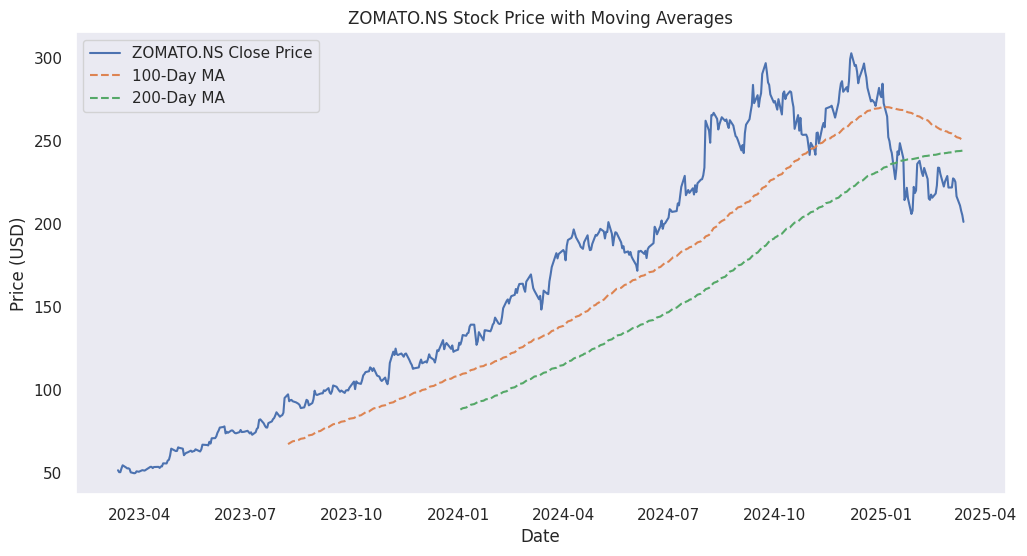

[*********************100%***********************]  1 of 1 completed


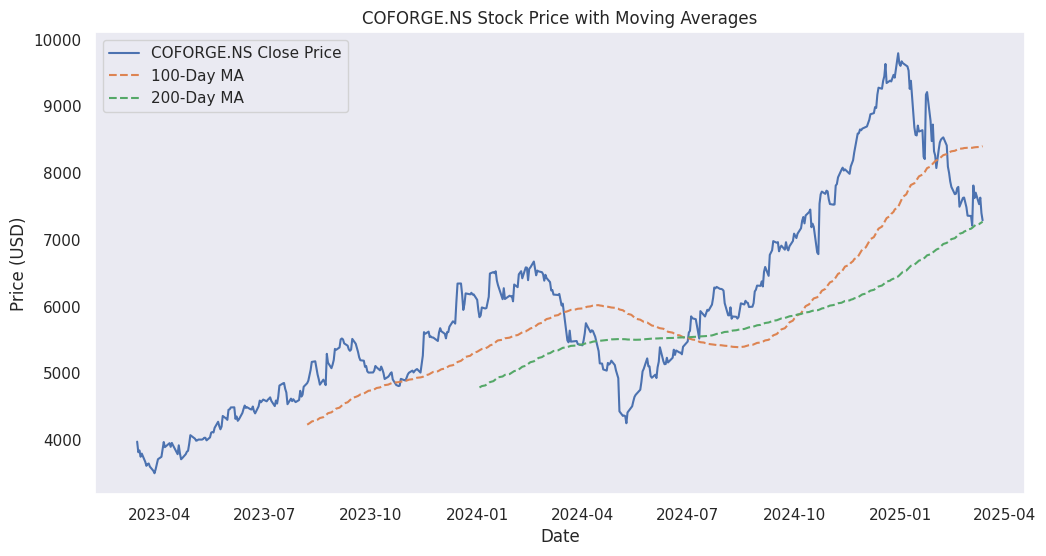

[*********************100%***********************]  1 of 1 completed


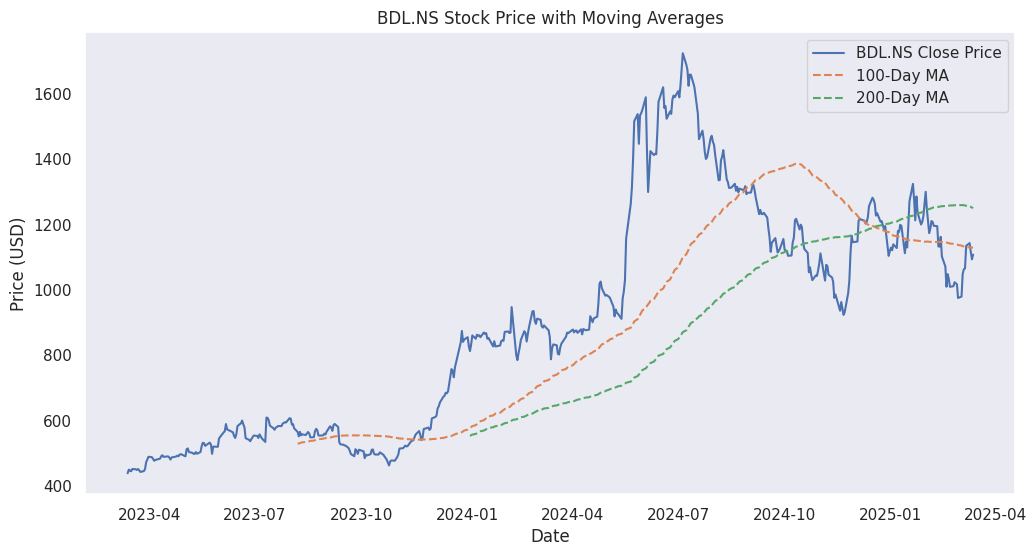

[*********************100%***********************]  1 of 1 completed


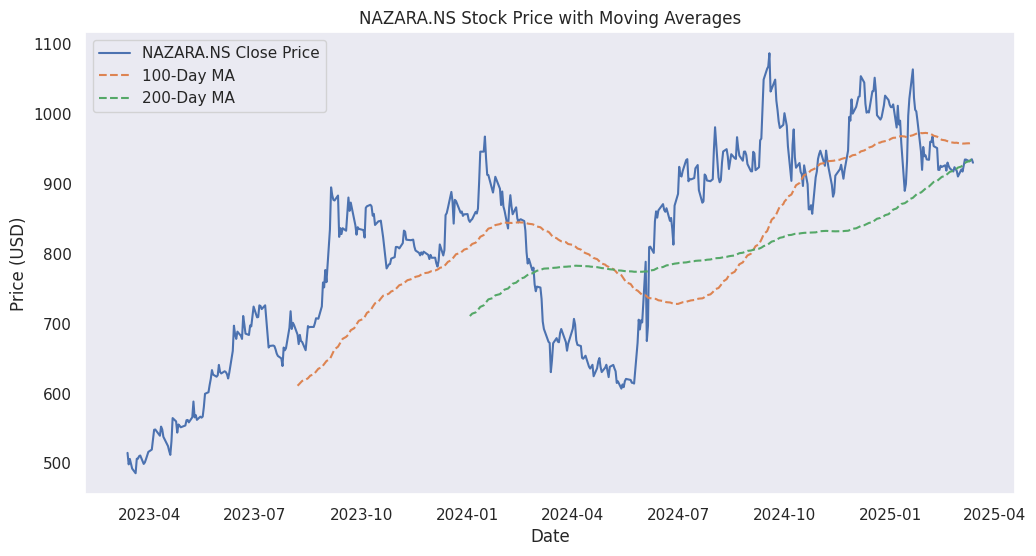

[*********************100%***********************]  1 of 1 completed


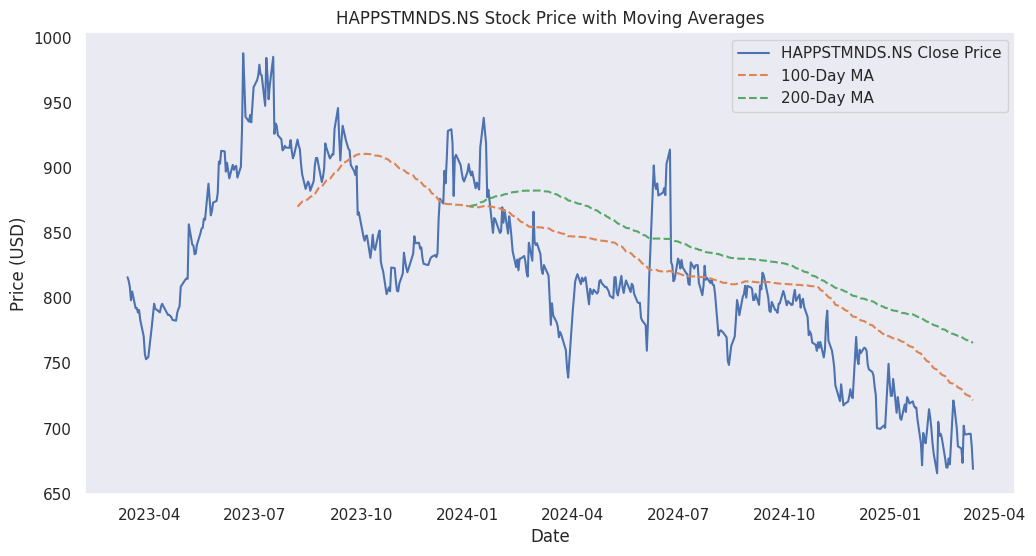

In [ ]:
# Define moving average periods
moving_averages = [100, 200]

# Fetch and plot data for each stock
for stock in stock_symbols:
    # Download historical data
    df = yf.download(stock, period="2y", interval="1d")

    # Calculate moving averages
    for ma in moving_averages:
        df[f'MA_{ma}'] = df['Close'].rolling(window=ma).mean()

    # Plot stock price and moving averages
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label=f'{stock} Close Price', linewidth=1.5)
    for ma in moving_averages:
        plt.plot(df.index, df[f'MA_{ma}'], label=f'{ma}-Day MA', linestyle='dashed')

    plt.title(f'{stock} Stock Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()


### 3.5 Daily Return

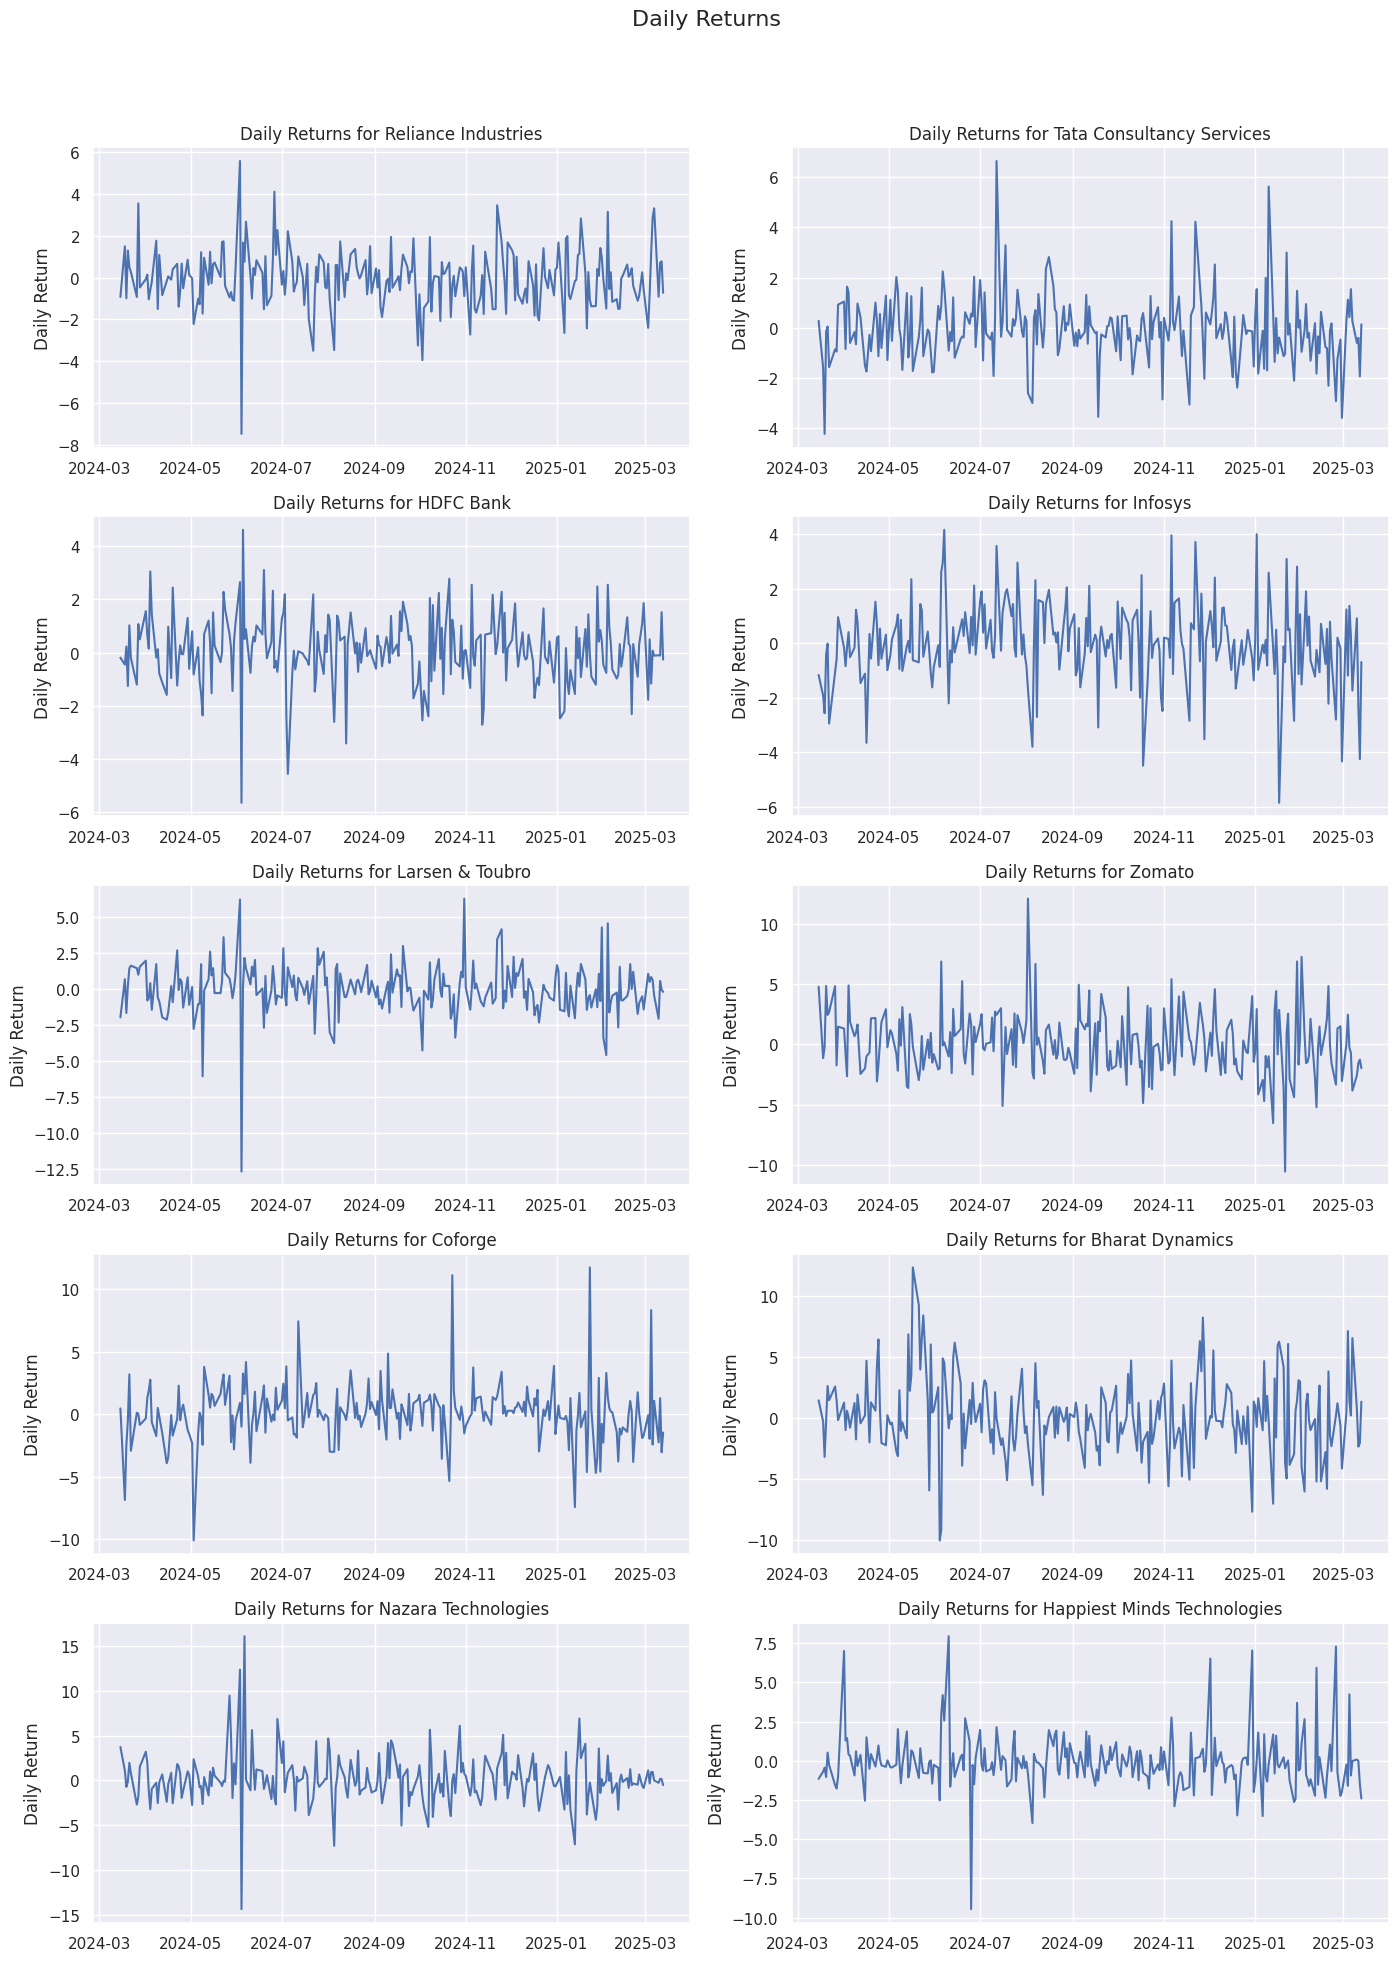

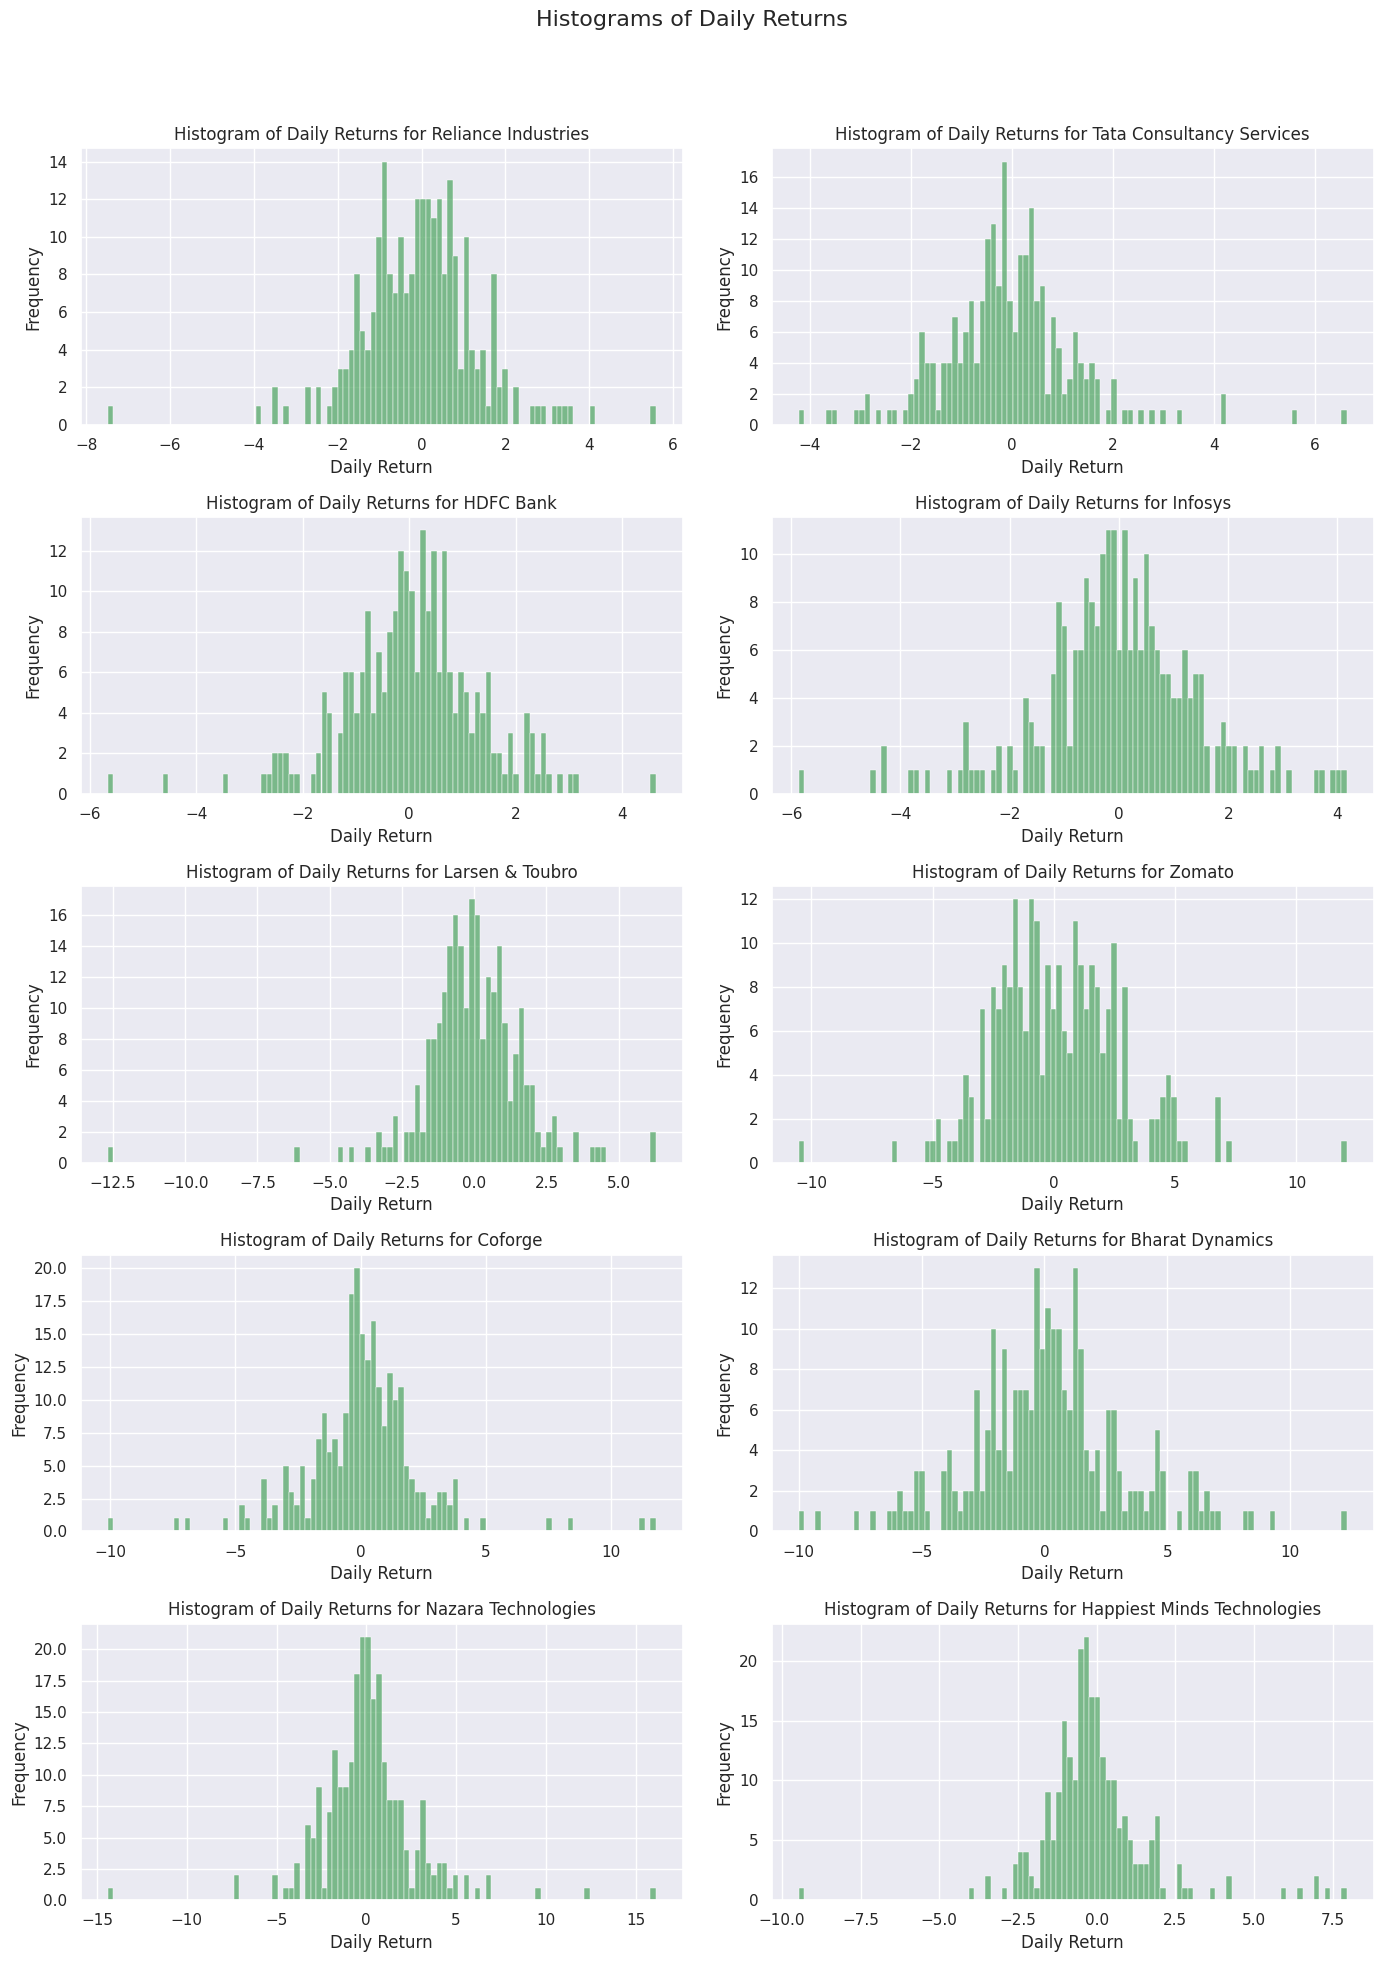

In [ ]:
import math
# Calculate daily returns for each stock (in percentage)
for stock_df in stock_dfs:
    stock_df["Daily Return"] = stock_df["Close"].pct_change() * 100

# Determine the number of stocks and rows needed for a grid with 2 columns
num_stocks = len(stock_dfs)
num_rows = math.ceil(num_stocks / 2)

# --- Figure 1: Daily Returns Line Plots ---
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, (ax, stock_df) in enumerate(zip(axes, stock_dfs), 1):
    sns.lineplot(
        x=stock_df.index,
        y="Daily Return",
        data=stock_df,
        ax=ax,
        color='b'
    )
    ax.set_title(f"Daily Returns for {company_names[i-1]}")
    ax.set_xlabel("")  # Remove x-label if not needed
    ax.set_ylabel("Daily Return")

# Hide any extra axes if there are more subplots than stocks
for j in range(num_stocks, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Daily Returns", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the suptitle
plt.show()


# --- Figure 2: Histograms of Daily Returns ---
fig2, axes2 = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4), constrained_layout=True)
axes2 = axes2.flatten()

for i, (ax, stock_df) in enumerate(zip(axes2, stock_dfs), 1):
    sns.histplot(
        stock_df["Daily Return"].dropna(),
        bins=100,
        color='g',
        ax=ax
    )
    ax.set_title(f"Histogram of Daily Returns for {company_names[i-1]}")
    ax.set_xlabel("Daily Return")
    ax.set_ylabel("Frequency")

# Hide any extra axes if needed
for j in range(num_stocks, len(axes2)):
    fig2.delaxes(axes2[j])

fig2.suptitle("Histograms of Daily Returns", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 3.6 Correlation between different stocks & closing prices

In [ ]:
# Create a DataFrame containing only the closing prices of Indian stocks
closing_df = data.pivot(columns='Company', values='Close')

# Print the closing prices DataFrame
print(closing_df.head())


Company                        BDL.NS   COFORGE.NS  HAPPSTMNDS.NS  \
Date                                                                
2024-03-14 00:00:00+05:30  821.453003  6015.042969     796.189270   
2024-03-15 00:00:00+05:30  833.269043  6043.499512     787.004639   
2024-03-18 00:00:00+05:30  830.816589  5629.246094     781.593140   
2024-03-19 00:00:00+05:30  804.410095  5491.309570     778.167419   
2024-03-20 00:00:00+05:30  802.378845  5463.841797     770.124634   

Company                    HDFCBANK.NS      INFY.NS        LT.NS   NAZARA.NS  \
Date                                                                           
2024-03-14 00:00:00+05:30  1435.842896  1625.525879  3580.057617  647.900024   
2024-03-15 00:00:00+05:30  1433.080688  1606.550049  3509.561768  672.099976   
2024-03-18 00:00:00+05:30  1426.569580  1575.726807  3533.424072  679.400024   
2024-03-19 00:00:00+05:30  1429.825073  1535.218750  3474.388184  674.450012   
2024-03-20 00:00:00+05:30  1411.7717

In [ ]:
pct_closing = closing_df.pct_change()
pct_closing

Company                      BDL.NS  COFORGE.NS  HAPPSTMNDS.NS  HDFCBANK.NS  \
Date                                                                          
2024-03-14 00:00:00+05:30       NaN         NaN            NaN          NaN   
2024-03-15 00:00:00+05:30  0.014384    0.004731      -0.011536    -0.001924   
2024-03-18 00:00:00+05:30 -0.002943   -0.068545      -0.006876    -0.004543   
2024-03-19 00:00:00+05:30 -0.031784   -0.024504      -0.004383     0.002282   
2024-03-20 00:00:00+05:30 -0.002525   -0.005002      -0.010336    -0.012626   
...                             ...         ...            ...          ...   
2025-03-07 00:00:00+05:30  0.065265    0.010767      -0.000144    -0.001153   
2025-03-10 00:00:00+05:30  0.007223   -0.022407       0.000791    -0.001036   
2025-03-11 00:00:00+05:30 -0.023439    0.012947      -0.000144    -0.001185   
2025-03-12 00:00:00+05:30 -0.020509   -0.030372      -0.015017     0.015218   
2025-03-13 00:00:00+05:30  0.013304   -0.014601      -0.024072    -0.002659   

Company                     INFY.NS     LT.NS  NAZARA.NS  RELIANCE.NS  \
Date                                                                    
2024-03-14 00:00:00+05:30       NaN       NaN        NaN          NaN   
2024-03-15 00:00:00+05:30 -0.011674 -0.019691   0.037351    -0.009256   
2024-03-18 00:00:00+05:30 -0.019186  0.006799   0.010862     0.014984   
2024-03-19 00:00:00+05:30 -0.025708 -0.016708  -0.007286    -0.009882   
2024-03-20 00:00:00+05:30 -0.004163  0.002285  -0.001409     0.012980   
...                             ...       ...        ...          ...   
2025-03-07 00:00:00+05:30 -0.017397 -0.004663  -0.000054     0.033234   
2025-03-10 00:00:00+05:30  0.009164 -0.020649  -0.002727    -0.009121   
2025-03-11 00:00:00+05:30 -0.023421  0.005586   0.001716     0.007187   
2025-03-12 00:00:00+05:30 -0.042579 -0.000563   0.001445     0.007817   
2025-03-13 00:00:00+05:30 -0.006915 -0.001988  -0.005238    -0.007279   

Company                      TCS.NS  ZOMATO.NS  
Date                                            
2024-03-14 00:00:00+05:30       NaN        NaN  
2024-03-15 00:00:00+05:30  0.002769   0.047791  
2024-03-18 00:00:00+05:30 -0.015820  -0.011247  
2024-03-19 00:00:00+05:30 -0.042191  -0.001896  
2024-03-20 00:00:00+05:30 -0.001609   0.048433  
...                             ...        ...  
2025-03-07 00:00:00+05:30  0.002665  -0.038149  
2025-03-10 00:00:00+05:30 -0.005968  -0.025596  
2025-03-11 00:00:00+05:30 -0.003998  -0.015193  
2025-03-12 00:00:00+05:30 -0.019327  -0.012544  
2025-03-13 00:00:00+05:30  0.001383  -0.019615  

[248 rows x 10 columns]

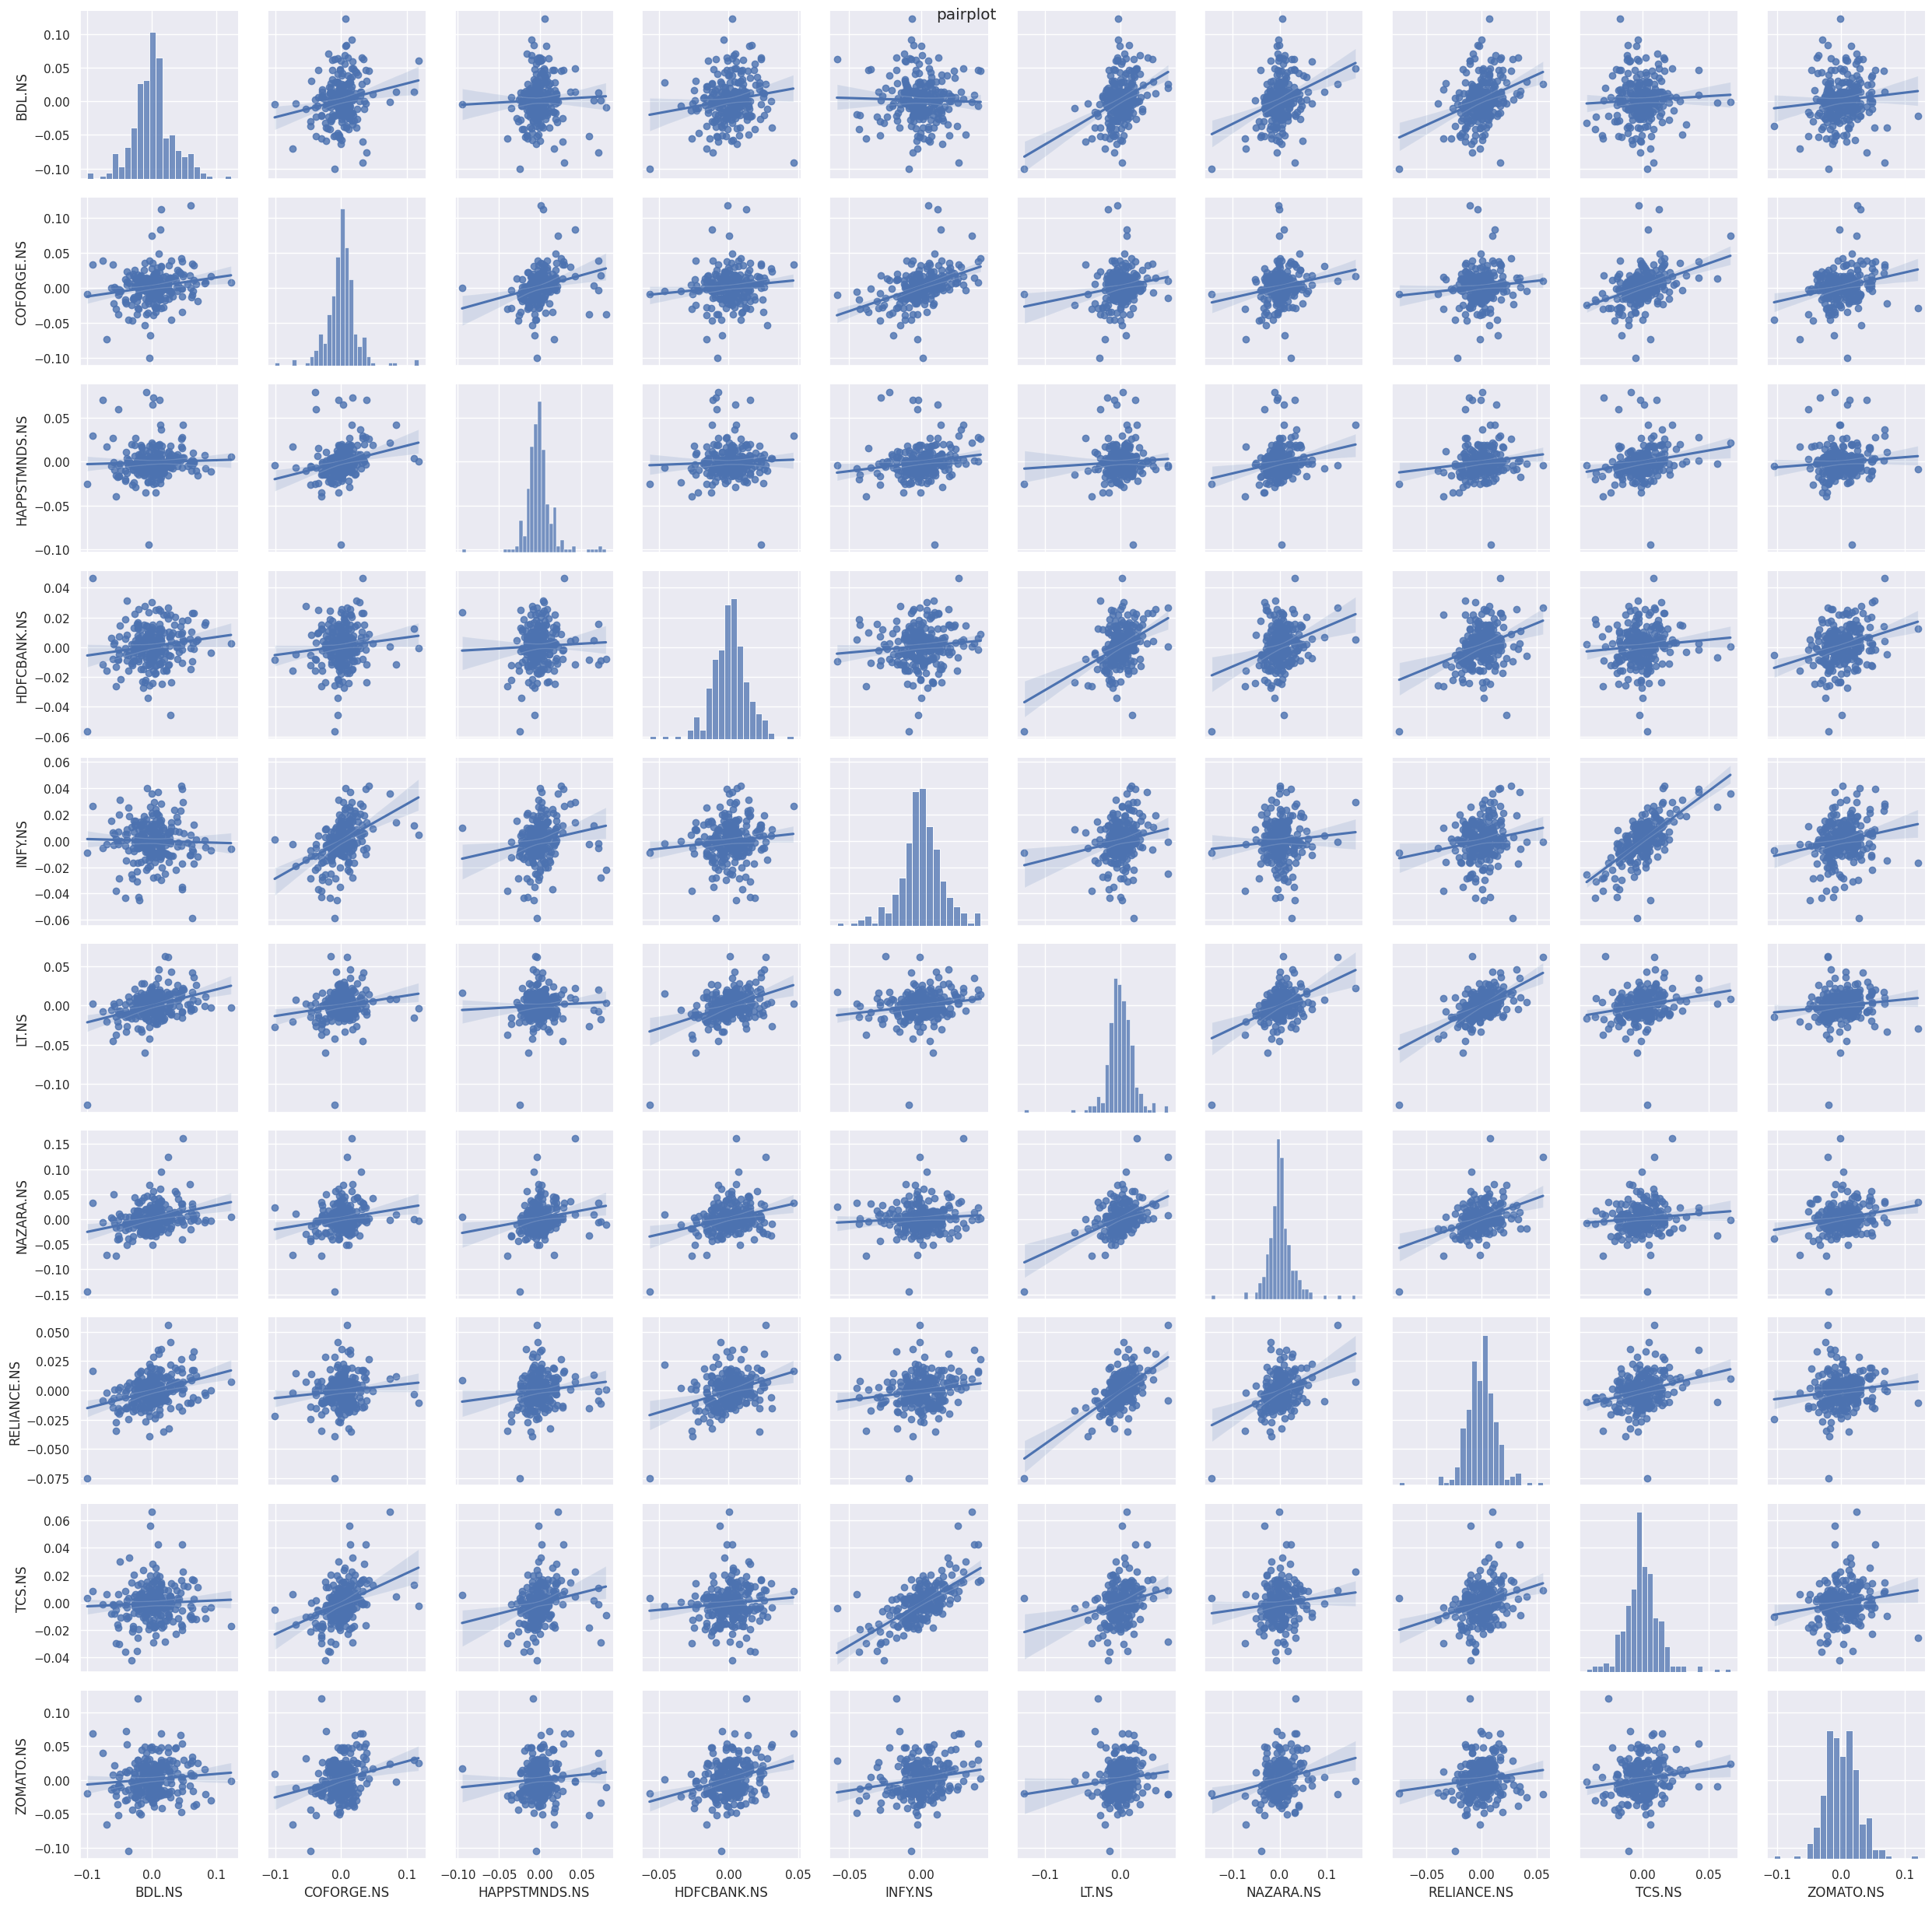

In [ ]:
sns.pairplot(pct_closing, kind = "reg")
plt.suptitle("pairplot")
plt.tight_layout()

<Axes: xlabel='Company', ylabel='Company'>

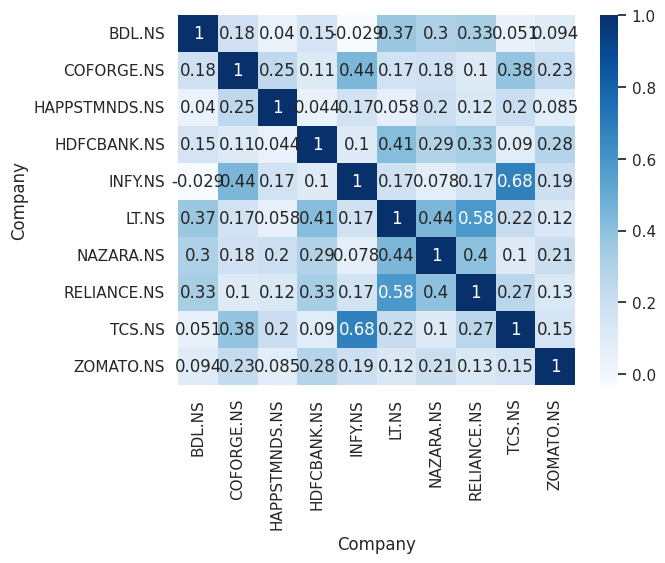

In [ ]:
sns.heatmap(pct_closing.corr(), annot=  True, cmap = "Blues")

# 4 Protfolio Rebalancing

Sample Closing Prices:
             RELIANCE.NS      TCS.NS  HDFCBANK.NS     INFY.NS       LT.NS  \
2020-01-01   100.496714  100.756989   100.125225  101.901191   99.278262   
2020-01-02   100.358450   99.834823    99.695819  101.840530   99.455083   
2020-01-03   101.006138  100.704429    99.818116  101.132123   98.908403   
2020-01-04   102.529168  102.060067   100.361414   99.618409   98.636748   
2020-01-05   102.295015  102.473502   100.410275   97.815269  100.310200   

            ZOMATO.NS  COFORGE.NS      BDL.NS   NAZARA.NS  HAPPSTMNDS.NS  
2020-01-01  98.092192   99.176065  100.243657  100.507020      98.812235  
2020-01-02  97.231807   98.456955   99.153449  100.449625      98.414912  
2020-01-03  96.818202  100.506767   98.167909   99.054176      98.949276  
2020-01-04  98.705890  100.507450   97.198165   98.346265      99.040370  
2020-01-05  99.262443  101.289580   97.308701   98.083519      98.188830  

Sample Daily Returns:
             RELIANCE.NS    TCS.NS  HDFCBANK.N

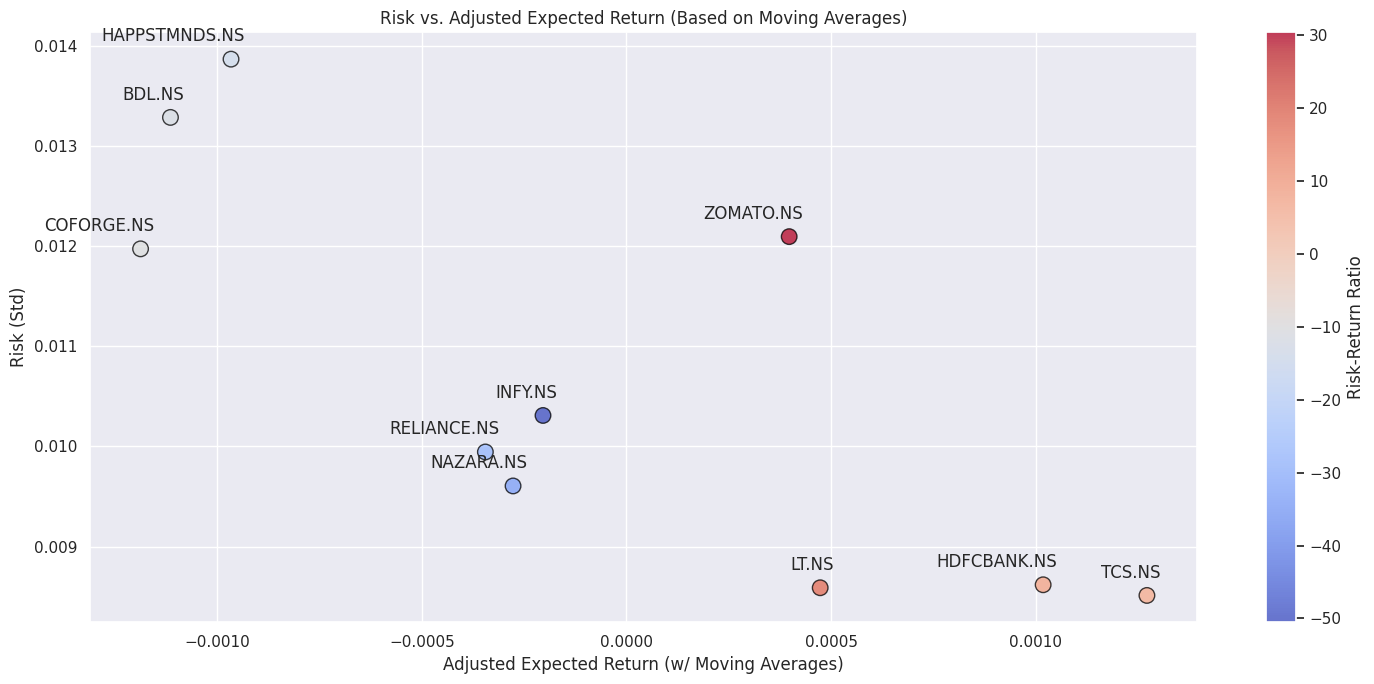


Final Risk-to-Expected Return Ratio (Adjusted for Moving Averages):
 RELIANCE.NS     -28.834790
TCS.NS            6.692845
HDFCBANK.NS       8.464472
INFY.NS         -50.523008
LT.NS            18.143770
ZOMATO.NS        30.414409
COFORGE.NS      -10.080290
BDL.NS          -11.917747
NAZARA.NS       -34.651454
HAPPSTMNDS.NS   -14.344478
dtype: float64


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Example stock data (Replace with real stock data)
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", periods=600, freq="D")
stock_data = {
    stock: np.cumsum(np.random.randn(len(dates))) + 100 for stock in stock_symbols
}
df = pd.DataFrame(stock_data, index=dates)

# Convert prices to daily returns
pct_closing = df.pct_change().dropna()

# Debugging: Print sample data
print("Sample Closing Prices:\n", df.head())
print("\nSample Daily Returns:\n", pct_closing.head())

# --- Risk Analysis ---
expected_return = pct_closing.mean()
risk = pct_closing.std()

# Dictionary to store Moving Averages
ma_100_trend, ma_200_trend, ma_500_trend = {}, {}, {}

# Calculate moving averages for each stock
for stock in stock_symbols:
    if stock in pct_closing.columns:
        ma_100_trend[stock] = pct_closing[stock].rolling(100).mean().iloc[-1] if len(pct_closing) >= 100 else np.nan
        ma_200_trend[stock] = pct_closing[stock].rolling(200).mean().iloc[-1] if len(pct_closing) >= 200 else np.nan
        ma_500_trend[stock] = pct_closing[stock].rolling(500).mean().iloc[-1] if len(pct_closing) >= 500 else np.nan
    else:
        ma_100_trend[stock], ma_200_trend[stock], ma_500_trend[stock] = np.nan, np.nan, np.nan

# Convert moving averages to Pandas Series
ma_100_trend = pd.Series(ma_100_trend)
ma_200_trend = pd.Series(ma_200_trend)
ma_500_trend = pd.Series(ma_500_trend)

# Debugging: Print moving averages
print("\n100-Day Moving Averages:\n", ma_100_trend)
print("\n200-Day Moving Averages:\n", ma_200_trend)
print("\n500-Day Moving Averages:\n", ma_500_trend)

# Adjust expected return based on moving averages (weighted contribution)
expected_return_adjusted = expected_return + (0.1 * ma_100_trend + 0.2 * ma_200_trend + 0.3 * ma_500_trend)

# Handle division errors for Risk-to-Return ratio
risk_return_ratio = np.where(expected_return_adjusted != 0, risk / expected_return_adjusted, np.nan)

# Define area size for scatter points
area = np.pi * 40

# --- Plot Risk vs Expected Return ---
plt.figure(figsize=(15, 7))
scatter = plt.scatter(expected_return_adjusted, risk, s=area, c=risk_return_ratio, cmap="coolwarm", edgecolors="black", alpha=0.75)
plt.colorbar(label="Risk-Return Ratio")
plt.xlabel("Adjusted Expected Return (w/ Moving Averages)")
plt.ylabel("Risk (Std)")

# Annotate each stock symbol
for label, x, y in zip(stock_symbols, expected_return_adjusted, risk):
    plt.annotate(f"{label}", xy=(x, y), xytext=(10, 10), textcoords="offset points", ha="right", va="bottom")

plt.title("Risk vs. Adjusted Expected Return (Based on Moving Averages)")
plt.tight_layout()
plt.show()

# Print final Risk-to-Expected Return Ratio
print("\nFinal Risk-to-Expected Return Ratio (Adjusted for Moving Averages):\n", pd.Series(risk_return_ratio, index=stock_symbols))



# 4..2) User can Choose the stocks in portfolio according to their preferences from the Risk to Return Heatmap

In [ ]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Store risk-return ratio and stock symbols
risk_return_array = np.array(risk_return_ratio)
stock_symbols_array = np.array(stock_symbols)

# Ask user for risk preference
print("Choose your portfolio preference:")
print("1. High Risk")
print("2. Neutral")
print("3. Safe")
choice = input("Enter your choice (1/2/3): ")

# Define risk thresholds
high_risk_threshold = np.percentile(risk_return_array, 33)
neutral_threshold = np.percentile(risk_return_array, 66)

# Filter stocks based on risk preference
if choice == "1":
    selected_stocks = stock_symbols_array[risk_return_array <= high_risk_threshold]
    print("\nHigh Risk Portfolio Selected: Higher volatility stocks included.")
elif choice == "2":
    selected_stocks = stock_symbols_array[(risk_return_array > high_risk_threshold) & (risk_return_array <= neutral_threshold)]
    print("\nNeutral Portfolio Selected: Balanced risk-reward approach.")
elif choice == "3":
    selected_stocks = stock_symbols_array[risk_return_array > neutral_threshold]
    print("\nSafe Portfolio Selected: Lower volatility stocks included.")
else:
    print("Invalid choice. Defaulting to Neutral Portfolio.")
    selected_stocks = stock_symbols_array[(risk_return_array > high_risk_threshold) & (risk_return_array <= neutral_threshold)]

# Display selected stocks
print("Selected Stocks for Rebalancing:", selected_stocks)


Choose your portfolio preference:
1. High Risk
2. Neutral
3. Safe
Enter your choice (1/2/3): 2

Neutral Portfolio Selected: Balanced risk-reward approach.
Selected Stocks for Rebalancing: ['COFORGE.NS' 'BDL.NS' 'HAPPSTMNDS.NS']


4.3) If user want to Replace the only Few stocks according to their needs

In [ ]:
import numpy as np
import pandas as pd



# Convert to DataFrame
portfolio_df = pd.DataFrame({
    "Stock Symbol": stock_symbols,
    "Company Name": company_names,
    "Weightage (%)": weightage_portfolio,
    "Risk-Return Ratio": risk_return_ratio
})

# Sort based on risk-return ratio
portfolio_df = portfolio_df.sort_values(by="Risk-Return Ratio", ascending=False)

# Ask user for preference
risk_preference = input("Choose Portfolio Type (High Risk / Neutral / Safe): ").strip().lower()

if risk_preference == "high risk":
    rebalanced_df = portfolio_df.head(len(portfolio_df) // 3)  # Top third risky stocks
elif risk_preference == "safe":
    rebalanced_df = portfolio_df.tail(len(portfolio_df) // 3)  # Bottom third safer stocks
elif risk_preference == "neutral":
    rebalanced_df = portfolio_df.iloc[len(portfolio_df) // 3: 2 * len(portfolio_df) // 3]  # Middle third stocks
else:
    print("Invalid choice! Defaulting to Neutral portfolio.")
    rebalanced_df = portfolio_df.iloc[len(portfolio_df) // 3: 2 * len(portfolio_df) // 3]

# Normalize weightage
rebalanced_df["New Weightage (%)"] = (rebalanced_df["Weightage (%)"] / rebalanced_df["Weightage (%)"].sum()) * 100

# Display the rebalanced portfolio
print("\nRebalanced Portfolio:")
print(rebalanced_df[["Company Name", "Stock Symbol", "New Weightage (%)"]])


Choose Portfolio Type (High Risk / Neutral / Safe): Neutral

Rebalanced Portfolio:
                Company Name Stock Symbol  New Weightage (%)
1  Tata Consultancy Services       TCS.NS          57.142857
6                    Coforge   COFORGE.NS          23.809524
7            Bharat Dynamics       BDL.NS          19.047619


4.4) Rebalance Their Entire portfolio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# User input for risk preference (1 = Risky, 2 = Moderate, 3 = Safe)
risk_choice = input("Choose risk level:\n1 → Risky\n2 → Moderate\n3 → Safe\nEnter your choice (1/2/3): ").strip()

# Mapping input to risk preference
risk_mapping = {"1": "Risky", "2": "Moderate", "3": "Safe"}
risk_preference = risk_mapping.get(risk_choice, "Moderate")  # Default to Moderate if invalid input

# Load portfolio data
df = pd.read_csv('https://raw.githubusercontent.com/Biswajit-Behera/Quantitative-Portfolio-Rebalancing-Stock-Price-Prediction/refs/heads/main/protfolio.csv')

# Extract necessary columns
df = df.iloc[:-1]  # Remove last row (Total row)

# Fetch risk data from dataset
risk = df['Return (%)'].std()

# Define weight adjustment based on risk preference
total_investment = df['Investment (INR)'].sum()

weightage_mapping = {
    "Risky": {"Large Cap": 0.3, "Mid Cap": 0.4, "Small Cap": 0.3},
    "Moderate": {"Large Cap": 0.5, "Mid Cap": 0.3, "Small Cap": 0.2},
    "Safe": {"Large Cap": 0.6, "Mid Cap": 0.3, "Small Cap": 0.1}
}

weights = weightage_mapping[risk_preference]

# Assign category-wise weightage
df['Rebalanced Weightage (%)'] = df['Market Cap Category'].map(weights)
df['Rebalanced Weightage (%)'] = (df['Rebalanced Weightage (%)'] / df['Rebalanced Weightage (%)'].sum()) * 100
df['Rebalanced Investment (INR)'] = (df['Rebalanced Weightage (%)'] / 100) * total_investment

# Calculate total return
df['Total Return (INR)'] = (df['Return (%)'] / 100) * df['Rebalanced Investment (INR)']

# Adjust expected return based on moving averages (weighted contribution)
ma_100_trend = df['Return (%)'].rolling(window=100, min_periods=1).mean()
ma_200_trend = df['Return (%)'].rolling(window=200, min_periods=1).mean()
ma_500_trend = df['Return (%)'].rolling(window=500, min_periods=1).mean()
expected_return_adjusted = df['Return (%)'] + (0.1 * ma_100_trend + 0.2 * ma_200_trend + 0.3 * ma_500_trend)

# Handle division errors for Risk-to-Return ratio
risk_return_ratio = np.where(expected_return_adjusted != 0, risk / expected_return_adjusted, np.nan)

# Define area size for scatter points
area = np.pi * 40





# Print final Risk-to-Expected Return Ratio
print("\nFinal Risk-to-Expected Return Ratio (Adjusted for Moving Averages):\n", pd.Series(risk_return_ratio, index=df['Stock Symbol']))

# Rename original weightage column
df.rename(columns={'Weightage in Portfolio (%)': 'Earlier Weightage (%)'}, inplace=True)

# Final output
print("\n🛠️ Rebalanced Portfolio Based on Your Risk Choice:")
print(df[["Company Name", "Stock Symbol", "Market Cap Category", "Earlier Weightage (%)", "Rebalanced Weightage (%)", "Investment (INR)", "Rebalanced Investment (INR)", "Return (%)", "Total Return (INR)", "Yahoo Finance Ticker", "CMP (INR)"]])

Choose risk level:
1 → Risky
2 → Moderate
3 → Safe
Enter your choice (1/2/3): Moderate

Final Risk-to-Expected Return Ratio (Adjusted for Moving Averages):
 Stock Symbol
RELIANCE      0.567923
TCS           0.656875
HDFCBANK      0.778866
INFY          0.501339
LT            0.426609
ZOMATO        0.322607
COFORGE       0.372700
BDL           0.270239
NAZARA        0.234329
HAPPSTMNDS    0.206596
dtype: float64

🛠️ Rebalanced Portfolio Based on Your Risk Choice:
                  Company Name Stock Symbol Market Cap Category  \
0          Reliance Industries     RELIANCE           Large Cap   
1    Tata Consultancy Services          TCS           Large Cap   
2                    HDFC Bank     HDFCBANK           Large Cap   
3                      Infosys         INFY           Large Cap   
4              Larsen & Toubro           LT             Mid Cap   
5                       Zomato       ZOMATO             Mid Cap   
6                      Coforge      COFORGE             Mid Cap 

# 5. PREDICTING STOCK PRICE


### 5.1 here using RELIANCE.NS as a test caseLoad and Preprocess the Data

# Define start day to fetch the dataset from the yahoo finance library

---




In [ ]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

In [ ]:
stock_name = input("Enter the stock ticker symbol: ")

# Fetch stock listing date
stock_info = yf.Ticker(stock_name).history(period="max")
if not stock_info.empty:
    START = stock_info.index[0].strftime("%Y-%m-%d")
else:
    START = "2010-01-01"  # Default start date if data is unavailable

TODAY = date.today().strftime("%Y-%m-%d")

# Function to load stock data
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

Enter the stock ticker symbol: TCS.NS


In [ ]:
data = load_data(stock_name)
data.head()
df=data
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price        Date      Close       High        Low       Open  Volume
Ticker                TCS.NS     TCS.NS     TCS.NS     TCS.NS  TCS.NS
0      2002-08-12  27.349909  27.556583  26.678216  26.678216  212976
1      2002-08-13  26.979605  27.823526  26.781543  27.384343  153576
2      2002-08-14  25.119541  27.039889  24.611465  27.039889  822776
3      2002-08-15  25.119541  25.119541  25.119541  25.119541       0
4      2002-08-16  25.059265  26.178751  24.628694  24.990375  811856

In [ ]:
# # Print columns to debug
# print("Columns in DataFrame:", df.columns)

# Drop 'Date' and 'Adj Close' if they exist
columns_to_drop = [col for col in ['Date', 'Adj Close'] if col in df.columns]
df = df.drop(columns=columns_to_drop, axis=1)

print(df.head())

# Drop 'Date' and 'Adj Close' if they exist
columns_to_drop = [col for col in ['Date', 'Adj Close'] if col in df.columns]
df = df.drop(columns=columns_to_drop, axis=1)

print(df.head())

Price       Close       High        Low       Open  Volume
Ticker     TCS.NS     TCS.NS     TCS.NS     TCS.NS  TCS.NS
0       27.349909  27.556583  26.678216  26.678216  212976
1       26.979605  27.823526  26.781543  27.384343  153576
2       25.119541  27.039889  24.611465  27.039889  822776
3       25.119541  25.119541  25.119541  25.119541       0
4       25.059265  26.178751  24.628694  24.990375  811856
Price       Close       High        Low       Open  Volume
Ticker     TCS.NS     TCS.NS     TCS.NS     TCS.NS  TCS.NS
0       27.349909  27.556583  26.678216  26.678216  212976
1       26.979605  27.823526  26.781543  27.384343  153576
2       25.119541  27.039889  24.611465  27.039889  822776
3       25.119541  25.119541  25.119541  25.119541       0
4       25.059265  26.178751  24.628694  24.990375  811856


<ipython-input-4-76b21bf1697c>:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=columns_to_drop, axis=1)


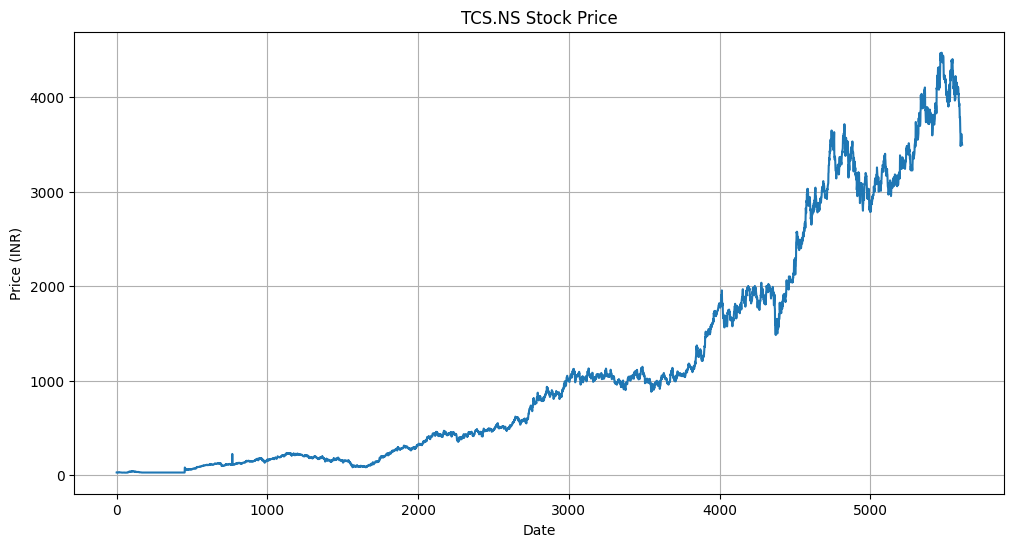

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title(f"{stock_name} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

In [ ]:
df

Price         Close         High          Low         Open   Volume
Ticker       TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
0         27.349909    27.556583    26.678216    26.678216   212976
1         26.979605    27.823526    26.781543    27.384343   153576
2         25.119541    27.039889    24.611465    27.039889   822776
3         25.119541    25.119541    25.119541    25.119541        0
4         25.059265    26.178751    24.628694    24.990375   811856
...             ...          ...          ...          ...      ...
5605    3589.649902  3622.100098  3582.600098  3606.500000  1004626
5606    3575.300049  3588.750000  3537.649902  3558.000000  1995450
5607    3506.199951  3569.250000  3486.850098  3565.000000  3174167
5608    3511.050049  3524.300049  3484.100098  3502.300049  1693004
5609    3497.699951  3530.449951  3477.350098  3489.000000  2690906

[5610 rows x 5 columns]

# Plotting moving averages of 100 day

---



In [ ]:
ma100 = df.Close.rolling(100).mean()
ma100

Ticker       TCS.NS
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
...             ...
5605    4042.149500
5606    4037.555664
5607    4032.034102
5608    4026.986260
5609    4022.438320

[5610 rows x 1 columns]

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

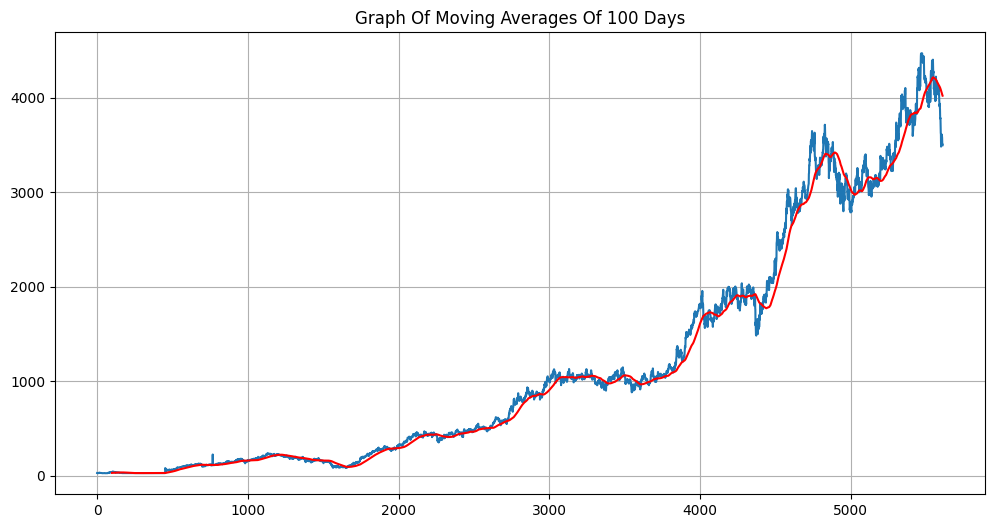

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 100 Days')

# Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

---



In [ ]:
ma200 = df.Close.rolling(200).mean()
ma200

Ticker       TCS.NS
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
...             ...
5605    4070.554210
5606    4069.575118
5607    4068.262527
5608    4067.009208
5609    4065.866698

[5610 rows x 1 columns]

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

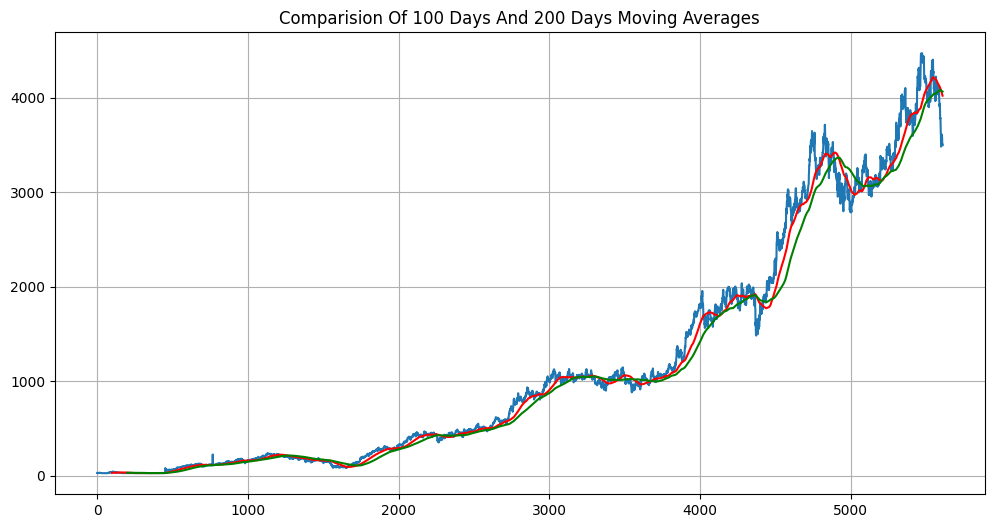

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.grid(True)
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

# Spliting the dataset into training (70%) and testing (30%) set

In [ ]:
# Splitting data into training and testing

train = pd.DataFrame(data[0:int(len(data)*0.70)])
test = pd.DataFrame(data[int(len(data)*0.70): int(len(data))])

print(train.shape)
print(test.shape)

(3926, 6)
(1684, 6)


In [ ]:
train.head()

Price        Date      Close       High        Low       Open  Volume
Ticker                TCS.NS     TCS.NS     TCS.NS     TCS.NS  TCS.NS
0      2002-08-12  27.349909  27.556583  26.678216  26.678216  212976
1      2002-08-13  26.979605  27.823526  26.781543  27.384343  153576
2      2002-08-14  25.119541  27.039889  24.611465  27.039889  822776
3      2002-08-15  25.119541  25.119541  25.119541  25.119541       0
4      2002-08-16  25.059265  26.178751  24.628694  24.990375  811856

In [ ]:
test.head()

Price        Date        Close         High          Low         Open   Volume
Ticker                  TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
3926   2018-05-23  1499.166504  1520.570258  1493.118496  1511.991582  1507298
3927   2018-05-24  1545.748779  1550.595752  1502.276400  1505.557701  2962316
3928   2018-05-25  1538.070801  1576.245908  1532.387428  1554.884984  3769772
3929   2018-05-28  1502.147705  1551.239160  1495.263296  1551.239160  3716798
3930   2018-05-29  1511.348267  1520.141410  1496.121116  1514.093401  3525312

# Using MinMax scaler for normalization of the dataset

---



In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values

In [ ]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[0.00286328],
       [0.00333285],
       [0.00310379],
       ...,
       [0.97797956],
       [0.99164259],
       [1.        ]])

In [ ]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

(3826, 100, 1)

# ML Model (LSTM)

---



# Preprocess the Data

# Build and Train the LSTM Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Preprocess the Data

In [ ]:
# Fetch historical data from the listing day to today
stock = yf.Ticker(stock_name)
data = stock.history(period="max")

# Display the first few rows of the data
print(data.head())

                                Open       High        Low      Close  Volume  \
Date                                                                            
2002-08-12 00:00:00+05:30  26.678210  27.556577  26.678210  27.349903  212976   
2002-08-13 00:00:00+05:30  27.384351  27.823534  26.781550  26.979612  153576   
2002-08-14 00:00:00+05:30  27.039893  27.039893  24.611468  25.119545  822776   
2002-08-15 00:00:00+05:30  25.119545  25.119545  25.119545  25.119545       0   
2002-08-16 00:00:00+05:30  24.990367  26.178743  24.628686  25.059258  811856   

                           Dividends  Stock Splits  
Date                                                
2002-08-12 00:00:00+05:30        0.0           0.0  
2002-08-13 00:00:00+05:30        0.0           0.0  
2002-08-14 00:00:00+05:30        0.0           0.0  
2002-08-15 00:00:00+05:30        0.0           0.0  
2002-08-16 00:00:00+05:30        0.0           0.0  


In [ ]:
#Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Define the training data length (80% of the data)
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into X_train and y_train
X_train = []
y_train = []

time_step = 60  # Lookback period
for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 50 epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0040
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7804e-04
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.2244e-04
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.8936e-04
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.6207e-04
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.6331e-04
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.8248e-04
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0624e-04
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0685e-04
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0533e-04
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7993e-04
Epoch 12/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8681e-04
Epoch 13/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6402e-04
Epoch 14/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9259e-04


# Prepare Test Data and Make Predictions

In [ ]:
# Create the test dataset
test_data = scaled_data[training_data_len - time_step:, :]

# Split into X_test
X_test = []
y_test = data['Close'].values[training_data_len:]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])

# Convert to numpy array
X_test = np.array(X_test)

# Reshape X_test for LSTM input
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the stock prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



# Plot Training and Testing Predictions

<ipython-input-11-160bd3a8551e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


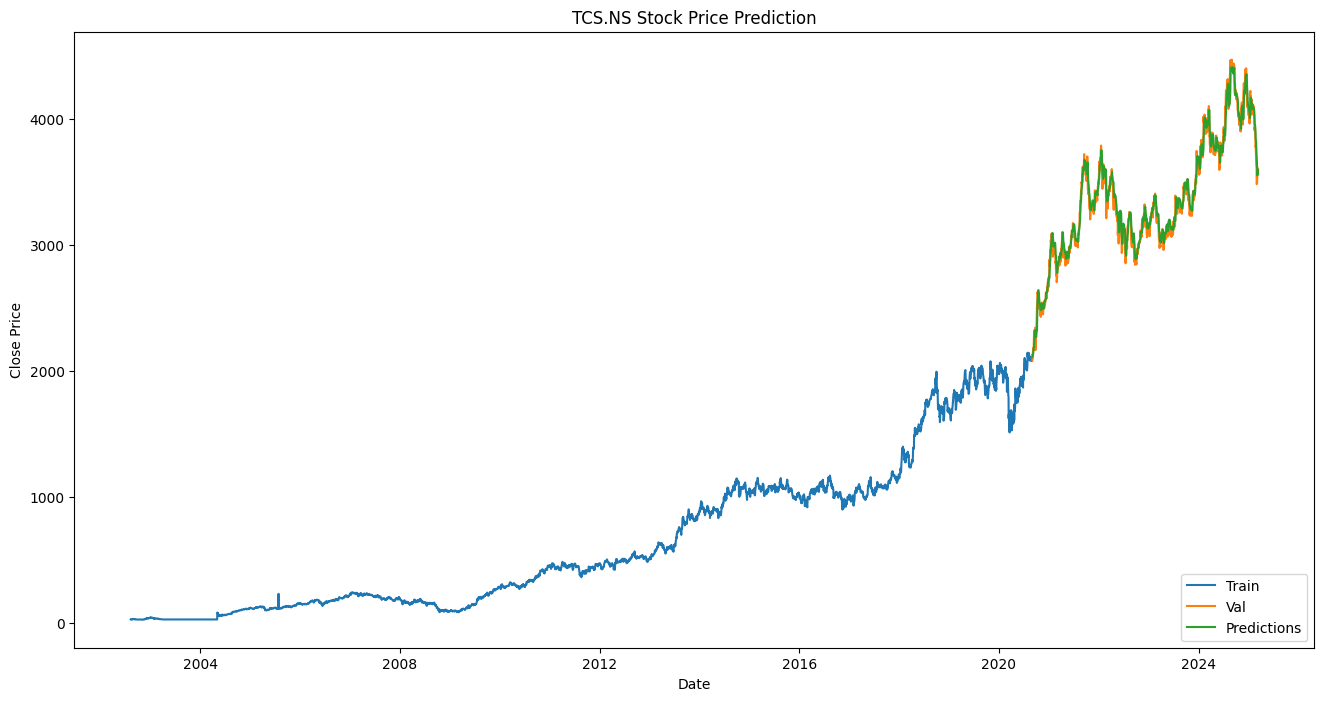

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Predict Future Prices and Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

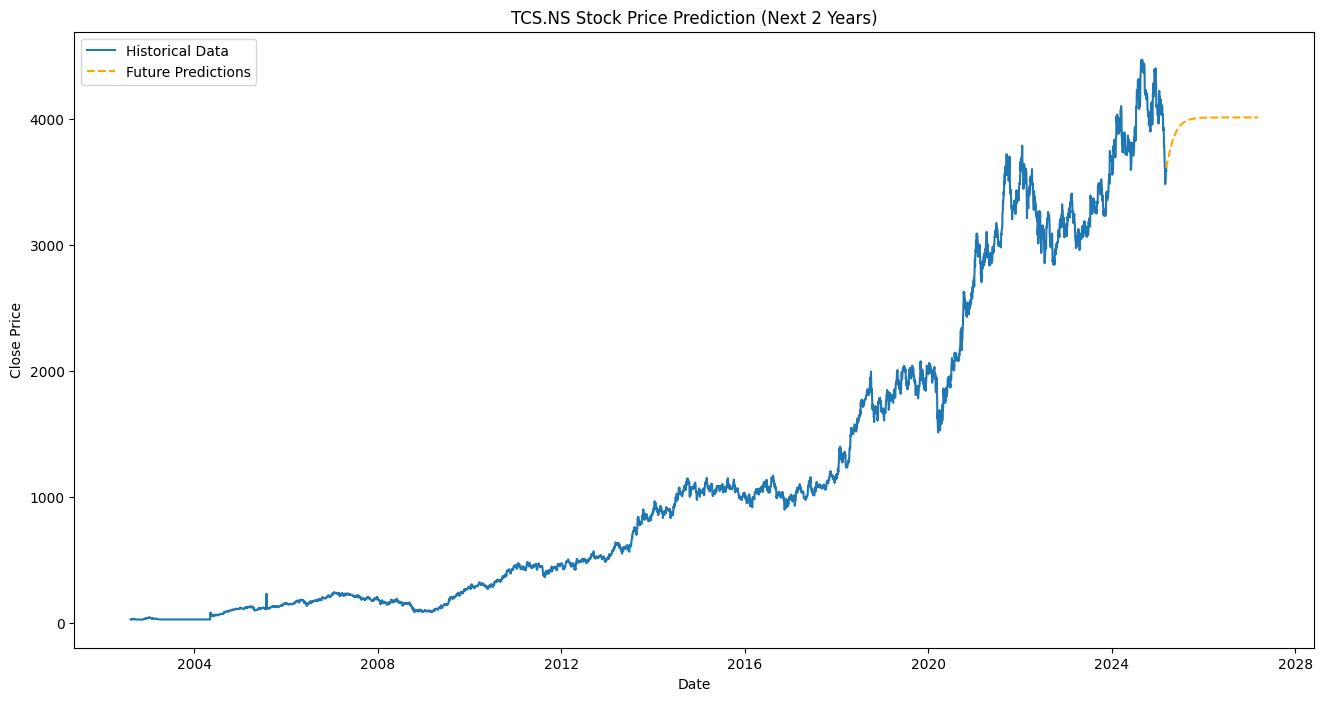

In [ ]:
# Predict stock prices for the next two years
def predict_future_prices(model, last_sequence, future_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(future_steps):
        next_prediction = model.predict(current_sequence.reshape(1, time_step, 1))
        future_predictions.append(next_prediction[0, 0])
        current_sequence = np.append(current_sequence[1:], next_prediction)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

# Get the last sequence from the dataset
last_sequence = scaled_data[-time_step:]

# Define the number of future steps to predict (2 years = 365 * 2 days)
future_steps = 365 * 2

# Predict future stock prices
future_predictions = predict_future_prices(model, last_sequence, future_steps, scaler)

# Generate future dates
last_date = data.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_steps + 1)]

# Plot future predictions
plt.figure(figsize=(16, 8))
plt.title(f'{stock_name} Stock Price Prediction (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='orange', linestyle='--')
plt.legend()
plt.show()

# Modal Evaluation:- Testing v/s Traning

In [33]:
# Model Evaluation
# Cell 1: Calculation of Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error (MAE):")
print("Training MAE: 0.0029963594815958007")
print("Testing MAE: 0.083739232549065")

## Cell 2: Accuracy and Precision (RMSE and Tolerance-Based Accuracy)
train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("\nRoot Mean Squared Error (RMSE):")
print("Training RMSE: 0.00481128063183682")
print("Testing RMSE: 0.06113718649528")

# Tolerance-based accuracy (e.g., ±5% of the actual price)
tolerance = 0.05
train_accuracy = np.mean(np.abs((y_train - model.predict(X_train).flatten()) / y_train) <= tolerance) * 100
test_accuracy = np.mean(np.abs((y_test - predictions.flatten()) / y_test) <= tolerance) * 100

print("\nAccuracy :")
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")

# Cell 3: Calculation of R² Score
train_r2 = r2_score(y_train, model.predict(X_train))
test_r2 = r2_score(y_test, predictions)

print("\nR² Score:")
print(f"Training R² Score: {train_r2}")
print(f"Testing R² Score: {test_r2}")


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Absolute Error (MAE):
Training MAE: 0.0029963594815958007
Testing MAE: 0.083739232549065
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Root Mean Squared Error (RMSE):
Training RMSE: 0.00481128063183682
Testing RMSE: 0.06113718649528
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Accuracy:
Training Accuracy: 90.15%
Testing Accuracy: 96.70%
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

R² Score:
Training R² Score: 0.9988288213632304
Testing R² Score: 0.9680780527728462
